<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2 Regression Challenge

_Authors: Joel Quek (SG)_

# Problem Statement

The question I wish to answer is: What are factors that have a great effect on housing price?

I will create models for housing price prediction based on multiple key factors.

1. Find the factors that have the greatest effect on housing price, particularly price per square feet

2. Find out the undervalued houses based on my model


# Table of Contents

* Import Libraries

* Cleaned Data Sets and Column Documentation

* Factor 1: Location and Proximity

* Factor 2: Quality and Condition of Home

* Factor 3: Parts of the Home

* Factor 4: Utilities and Intangible Factors

* Factor 5: Time Factors

* Overall

* Apply Model to Test Dataset

* Remodel Based on Sale Price [Kaggle Submission]

* Conclusions and Findings

# Import Libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso,RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  

from IPython.display import display #display allows display of all columns with headers

%matplotlib inline

In [2]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cleaned Data Sets and [Column Documentation](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

The data has been cleaned in another file titled 'project_2_data_clean.ipynb'

I grouped the data according to different classes of factors affecting house value
1. Location and Proximity to Amenities
2. Quality and Condition of the Home
3. Parts of the Home
4. Dimensions
5. Utilities and Intangible Factors
6. Time Factors
7. Price Factors

Documentation of the column headers can be found at the [Journal of Statistics Education](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [3]:
location_proximity_df=pd.read_csv('location_proximity.csv')
quality_condition_df=pd.read_csv('quality_condition.csv')
parts_of_home_df=pd.read_csv('parts_of_home.csv')
dimensions_df=pd.read_csv('dimensions.csv')
utilities_intangible_df=pd.read_csv('utilities_intangible.csv')
time_factors_df=pd.read_csv('time_factors.csv')
price_factors_df=pd.read_csv('price_factors.csv')

# Factor 1: Location and Proximity 

In [4]:
location_proximity_df.drop(['Unnamed: 0', 'Neighborhood'], axis=1, inplace=True)
price_factors_df.drop(['Unnamed: 0', 'Sale Type','SalePrice'], axis=1, inplace=True)
location_proximity_price_df = location_proximity_df.join(price_factors_df, how='outer')
print(location_proximity_price_df.shape)
location_proximity_price_df.head(3)

(1887, 11)


,MS SubClass,MS Zoning,Lot Config,Condition 1,Condition 2,Bldg Type,Land Contour,Land Slope,Street,Lot Shape,Price Per Sq Ft
0,2 Storey 1946 Newer,Residential Low Density,CulDSac,RRAe,Norm,1Fam,Lvl,Gtl,Pave,IR1,9.654509
1,2 Storey 1946 Newer,Residential Low Density,CulDSac,Norm,Norm,1Fam,Lvl,Gtl,Pave,IR1,19.143752
2,1 Storey Newer All,Residential Low Density,Inside,Norm,Norm,1Fam,Lvl,Gtl,Pave,Reg,13.759152


**Dropping the Neighbourhood Data**

You must be wondering why I am not including the neighbourhood data in my analysis.

Initially I included the 'Neighbourhood' data in the modelling, but the result was that the coefficients for 'Bldg Type_Duplex' and 'MS SubClass_Duplex All' were unusually large. I removed the neighbourhood data and did a re-modelling (get the pun?).

---

## Data Dictionary

|Header|Remarks|
|----|----|
|MS SubClass (Nominal): | Identifies the type of dwelling involved in the sale.|
|MS Zoning (Nominal): | Identifies the general zoning classification of the sale.|
|Lot Config (Nominal): | Lot configuration|
|[DROPPED] Neighborhood (Nominal): | Physical locations within Ames city limits |
|Condition 1 (Nominal): | Proximity to various conditions|
|Condition 2 (Nominal): | Proximity to various conditions (if more than one is present)|
|Bldg Type (Nominal): | Type of dwelling|
|Land Contour (Nominal): | Flatness of the property|
|Land Slope (Ordinal): | Slope of property|
|Street (Nominal): | Type of road access to property|
|Lot Shape (Ordinal): | General shape of property|


In [5]:
location_proximity_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MS SubClass      1887 non-null   object 
 1   MS Zoning        1887 non-null   object 
 2   Lot Config       1887 non-null   object 
 3   Condition 1      1887 non-null   object 
 4   Condition 2      1887 non-null   object 
 5   Bldg Type        1887 non-null   object 
 6   Land Contour     1887 non-null   object 
 7   Land Slope       1887 non-null   object 
 8   Street           1887 non-null   object 
 9   Lot Shape        1887 non-null   object 
 10  Price Per Sq Ft  1887 non-null   float64
dtypes: float64(1), object(10)
memory usage: 162.3+ KB


There are some variables that might be correlated.

Also I will need to know which variables are **qualitative** and which are **quantitative** [referring to 4.02 lab]

Given that all the datatypes are objects (except price per sq feet), this means I need to hot-encode the object data 

---

## Hot Encode Categorical Data [via get_dummies]

In [6]:
location_proximity_price_df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Config', 'Condition 1', 'Condition 2',
       'Bldg Type', 'Land Contour', 'Land Slope', 'Street', 'Lot Shape',
       'Price Per Sq Ft'],
      dtype='object')

In [7]:
location_proximity_price_dummies_df = pd.get_dummies(location_proximity_price_df,columns=['MS SubClass', 'MS Zoning', 'Lot Config', 'Condition 1',
       'Condition 2', 'Bldg Type', 'Land Contour', 'Land Slope', 'Street',
       'Lot Shape'], drop_first=True)

print(location_proximity_price_dummies_df.shape)
pd.set_option('display.max_columns', None)

location_proximity_price_dummies_df.head(3)


(1887, 52)


,Price Per Sq Ft,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg
0,9.654509,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,19.143752,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,13.759152,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


## Correlation of Various Location and Proximity Factors

In [8]:
location_proximity_price_dummies_df.corr()

,Price Per Sq Ft,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg
Price Per Sq Ft,1.000000,-0.249424,0.455424,-0.018491,-0.128728,0.115060,-0.018720,-0.000270,-0.042571,0.568168,-0.030436,-5.141445e-02,-0.090446,0.135922,-0.097095,-0.055449,0.340090,0.012900,-0.301127,0.143416,-0.080020,0.059191,-0.018496,1.363747e-01,-0.108601,0.169933,-0.019992,-0.001996,-0.066481,-0.057425,-0.027517,-0.013221,-0.037576,0.028186,0.021940,0.043665,-0.021321,-0.018060,-0.022799,-0.089883,-5.141445e-02,0.542174,0.524391,0.122387,-0.097536,0.022312,0.000848,-0.072938,0.046777,-0.058519,-0.048025,0.069209
MS SubClass_1 Storey Newer All,-0.249424,1.000000,-0.216712,-0.036569,-0.257649,-0.018270,-0.054927,-0.405632,-0.169113,-0.170189,-0.068597,-1.122082e-01,-0.100847,-0.051772,-0.173381,-0.095595,-0.066233,-0.032162,0.293210,-0.286094,0.051241,-0.016306,-0.001518,-3.669525e-02,0.049374,-0.002065,0.046060,0.051039,0.061700,-0.054959,0.022975,-0.025479,-0.042922,0.031779,0.022975,0.022975,-0.018270,-0.018270,0.007604,-0.092146,-1.122082e-01,-0.146243,-0.236760,-0.003624,0.060491,0.011814,0.015577,0.039858,-0.010760,0.000903,-0.039129,-0.046402
MS SubClass_1 Storey PUD,0.455424,-0.216712,1.000000,-0.012589,-0.088694,-0.006289,-0.018908,-0.139636,-0.058216,-0.058586,-0.023614,-3.862677e-02,-0.034716,-0.017822,-0.059685,-0.032908,0.074994,0.088637,-0.095212,0.047699,-0.014065,0.105001,0.014268,3.476728e-02,-0.060768,0.094971,-0.021851,-0.015351,-0.027546,-0.038091,-0.010899,-0.015426,-0.019936,0.012394,-0.010899,0.041433,-0.006289,-0.006289,-0.008897,-0.034716,-3.862677e-02,0.090012,0.795340,0.115635,-0.023589,-0.035016,0.053257,-0.018908,0.012589,0.040657,0.011354,-0.070503
MS SubClass_1 Storey W/Finished Attic,-0.018491,-0.036569,-0.012589,1.000000,-0.014967,-0.001061,-0.003191,-0.023563,-0.009824,-0.009886,-0.003985,-6.518082e-03,-0.005858,-0.003007,-0.010072,-0.005553,-0.010903,-0.003529,-0.032931,0.046555,-0.012276,-0.007835,-0.003007,-2.384196e-02,-0.010254,-0.015779,-0.003687,-0.005553,-0.004648,0.077801,-0.001839,-0.002603,0.155339,-0.097595,-0.001839,-0.001839,-0.001061,-0.001061,-0.001501,-0.005858,-6.518082e-03,-0.008495,-0.013981,-0.009824,-0.006518,-0.061840,0.046304,-0.003191,0.002124,-0.007911,-0.003191,0.036528
MS SubClass_1.5 Finished,-0.128728,-0.257649,-0.088694,-0.014967,1.000000,-0.007477,-0.022480,-0.166013,-0.069213,-0.069653,-0.028075,-4.592345e-02,-0.041274,-0.021189,-0.070960,-0.039124,-0.076817,-0.001168,-0.187669,0.256210,-0.071984,-0.044283,-0.021189,3.919524e-02,0.012853,-0.079350,-0.025978,-0.039124,-0.032750,0.020651,-0.012958,0.013704,0.050841,-0.043640,-0.012958,-0.012958,-0.007477,-0.007477,-0.010577,-0.041274,-4.592345e-02,-0.059853,-0.098502,0.010424,-0.006889,-0.049281,0.009525,0.003705,0.014967,-0.034095,0.003705,0.168416
MS SubClass_1.5 Storey PUD,0.115060,-0.018270,-0.006289,-0.001061,-0.007477,1.000000,-0.001594,-0.011772,-0.004908,-0.004939,-0.001991,-3.256448e-03,-0.002927,-0.001502,-0.005032,-0.002774

## Model 1: Linear Regression on Location and Proximity Factors

### Step 1: Assemble our predictor variables (X) and our target (y) 

I will perform linear regression on Location and PRoximity Factors against the Price per Square Feet

In [9]:
X = location_proximity_price_dummies_df.drop(columns = ["Price Per Sq Ft"])
y = location_proximity_price_dummies_df["Price Per Sq Ft"]

Note that X has been "dummified" earlier

In [10]:
X.head()

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [11]:
y

0        9.654509
1       19.143752
2       13.759152
3       17.751479
4        9.729540
          ...    
1882    26.094069
1883     6.684492
1884    23.418894
1885    13.846154
1886    25.200000
Name: Price Per Sq Ft, Length: 1887, dtype: float64

### Step 2: Instantiate the model

In [12]:
model = LinearRegression()

### Step 3: Fit the model

In [13]:
model.fit(X,y)

LinearRegression()

### Step 4: Coefficients 

In [14]:
X.columns

Index(['MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD',
       'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished',
       'MS SubClass_1.5 Storey PUD', 'MS SubClass_1.5 Unfinished',
       'MS SubClass_2 Storey 1946 Newer', 'MS SubClass_2 Storey 1946 Older',
       'MS SubClass_2 Storey PUD', 'MS SubClass_2.5 Story All',
       'MS SubClass_Duplex All', 'MS SubClass_Family Conversion',
       'MS SubClass_PUD Multi', 'MS SubClass_Split', 'MS SubClass_Split Foyer',
       'MS Zoning_Floating Village Residential',
       'MS Zoning_Residential High Density',
       'MS Zoning_Residential Low Density',
       'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA',
       'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn',
       'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Feedr',
       'Condition 2_Norm', 

In [15]:
model.coef_

array([ 4.36464575, 19.58543506,  3.01295435,  2.74286711, 46.73700924,
        4.02152439,  8.33746162,  5.0560908 , 24.36115139,  2.58623112,
        2.02255557,  2.43302371, 18.90379738,  2.9975256 ,  3.19432763,
       13.6271917 ,  2.0083537 ,  5.42173887,  7.23955464, -0.14158921,
       -1.60873221, -2.21814436,  1.15998912,  1.1328909 ,  2.40047282,
       -1.0120883 ,  4.75542479, -2.80555789,  0.09798195,  0.8014541 ,
        2.1850937 ,  1.626588  ,  0.80897753, 11.17851911,  6.90397776,
       -5.46347643, -2.45693657, -5.33717295, -2.84213421,  2.02255557,
       20.50299873,  8.00401174,  6.96454081, -2.86140344,  1.23280093,
        0.8979427 , -6.04332536,  4.38458006, -4.25854575, -8.0017232 ,
        0.76921319])

In [16]:
coef_dict = dict(zip(X.columns, model.coef_))
coef_dict

{'MS SubClass_1 Storey Newer All': 4.36464574590268,
 'MS SubClass_1 Storey PUD': 19.585435063270133,
 'MS SubClass_1 Storey W/Finished Attic': 3.0129543521236086,
 'MS SubClass_1.5 Finished': 2.7428671120099177,
 'MS SubClass_1.5 Storey PUD': 46.73700923611713,
 'MS SubClass_1.5 Unfinished': 4.021524393643372,
 'MS SubClass_2 Storey 1946 Newer': 8.33746161519583,
 'MS SubClass_2 Storey 1946 Older': 5.056090803042413,
 'MS SubClass_2 Storey PUD': 24.36115138918518,
 'MS SubClass_2.5 Story All': 2.5862311230515522,
 'MS SubClass_Duplex All': 2.022555571125983,
 'MS SubClass_Family Conversion': 2.4330237126189123,
 'MS SubClass_PUD Multi': 18.903797380249312,
 'MS SubClass_Split': 2.9975255963514265,
 'MS SubClass_Split Foyer': 3.194327630140751,
 'MS Zoning_Floating Village Residential': 13.627191697140546,
 'MS Zoning_Residential High Density': 2.008353697368707,
 'MS Zoning_Residential Low Density': 5.421738865804948,
 'MS Zoning_Residential Medium Density': 7.239554643687749,
 'Lot C

Sort Coefficient Dictionary based on Coefficient Strength

I sort the coefficients to check which have the greatest effect

In [17]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

# source https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value

{'Lot Shape_IR3': -8.00172320385965,
 'Land Slope_Sev': -6.043325362026236,
 'Condition 2_RRAe': -5.46347643305961,
 'Condition 2_RRNn': -5.337172949471586,
 'Lot Shape_IR2': -4.258545751984268,
 'Land Contour_Low': -2.861403435233408,
 'Bldg Type_2fmCon': -2.8421342131348246,
 'Condition 1_RRAe': -2.805557893172365,
 'Condition 2_RRAn': -2.456936568300069,
 'Lot Config_FR3': -2.2181443612791623,
 'Lot Config_FR2': -1.6087322052464286,
 'Condition 1_PosA': -1.012088304687408,
 'Lot Config_CulDSac': -0.1415892133681909,
 'Condition 1_RRAn': 0.09798194816903866,
 'Lot Shape_Reg': 0.7692131920240923,
 'Condition 1_RRNe': 0.8014541032287255,
 'Condition 2_Norm': 0.8089775297246052,
 'Land Slope_Mod': 0.8979426951029558,
 'Condition 1_Feedr': 1.132890898427272,
 'Lot Config_Inside': 1.1599891247774314,
 'Land Contour_Lvl': 1.232800932534156,
 'Condition 2_Feedr': 1.6265879962325838,
 'MS Zoning_Residential High Density': 2.008353697368707,
 'MS SubClass_Duplex All': 2.022555571125983,
 'Bld

In [18]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}


{'MS SubClass_1.5 Storey PUD': 46.73700923611713,
 'MS SubClass_2 Storey PUD': 24.36115138918518,
 'Bldg Type_Twnhs': 20.50299873154703,
 'MS SubClass_1 Storey PUD': 19.585435063270133,
 'MS SubClass_PUD Multi': 18.903797380249312,
 'MS Zoning_Floating Village Residential': 13.627191697140546,
 'Condition 2_PosA': 11.17851910651528,
 'MS SubClass_2 Storey 1946 Newer': 8.33746161519583,
 'Bldg Type_TwnhsE': 8.004011742678237,
 'MS Zoning_Residential Medium Density': 7.239554643687749,
 'Land Contour_HLS': 6.964540806199096,
 'Condition 2_PosN': 6.903977758956987,
 'MS Zoning_Residential Low Density': 5.421738865804948,
 'MS SubClass_2 Storey 1946 Older': 5.056090803042413,
 'Condition 1_PosN': 4.755424786753469,
 'Street_Pave': 4.3845800599747875,
 'MS SubClass_1 Storey Newer All': 4.36464574590268,
 'MS SubClass_1.5 Unfinished': 4.021524393643372,
 'MS SubClass_Split Foyer': 3.194327630140751,
 'MS SubClass_1 Storey W/Finished Attic': 3.0129543521236086,
 'MS SubClass_Split': 2.9975255

#### Interpretation of Coefficients

Reminder to self: Refer to lecture 3.01 Linear Regression

- The effect of a home being 'MS SubClass_1.5 Storey PUD' contributes to the price per square feet increasing by 46.737

- The effect of a home being 'MS SubClass_2 Storey PUD' contributes to the price per square feet increasing by 24.361

- The effect of a home being 'Lot Shape_IR3' contributes to the price per square feet decreasing by 8.001

- The effect of a home being 'Land Slope_Sev' contributes to the price per square feet decreasing by 6.043

Here are other effects on Price per Square Feet

Factors with Positive Effect on Price

- 'Bldg Type_Twnhs': 20.50299873154703,
- 'MS SubClass_1 Storey PUD': 19.585435063270133,
- 'MS SubClass_PUD Multi': 18.903797380249312,
- 'MS Zoning_Floating Village Residential': 13.627191697140546,
- 'Condition 2_PosA': 11.17851910651528,

Factors with Negative Effect on Price

- 'Condition 2_RRAe': -5.46347643305961,
- 'Condition 2_RRNn': -5.337172949471586,
- 'Lot Shape_IR2': -4.258545751984268,
- 'Land Contour_Low': -2.861403435233408,

### Step 5: Make Predictions

In [19]:
X.head(3)

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1


In [20]:
y_preds = model.predict(X)
y_preds # y_preds are points on the regression plane 
# y_preds are the predicted price per square feet

array([15.38300917, 20.58903989, 18.68701555, ..., 15.83243599,
       17.52702643, 22.65983142])

### Step 6: Evaluate the model

$R^2$

In [21]:
# R2:
metrics.r2_score(y, y_preds)

0.6944707123084155

69.4% of the data fall on the regression plane. Decent but not great!

MSE

In [22]:
# MSE:
metrics.mean_squared_error(y, y_preds) 

51.95700367033721

How is our model?

It is ok. Score is not high but decent enough that I will not need to regularize.

---

# Factor 2: Quality and Condition of Home

In [23]:
# price_factors_df.drop(['Sale Type','SalePrice'], axis=1, inplace=True)
price_factors_df.head()

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540


In [24]:
quality_condition_df.drop('Unnamed: 0', axis=1, inplace=True)
# quality_condition_price_df = location_proximity_df.join(price_factors_df, how='outer')
print(quality_condition_df.shape)
quality_condition_df.head(3)

(1887, 7)


,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional,Garage Qual,Garage Cond
0,6,8,4,3,Typ,TA,TA
1,7,5,4,3,Typ,TA,TA
2,5,7,3,4,Typ,TA,TA


## Data Dictionary

|Factor|Elaboration|
|----|----|
|Overall Qual (Ordinal): | Rates the overall material and finish of the house|
|Overall Cond (Ordinal): |Rates the overall condition of the house|
Exter Qual (Ordinal): |Evaluates the quality of the material on the exterior|
Exter Cond (Ordinal): |Evaluates the present condition of the material on the exterior|
Functional (Ordinal): |Home functionality (Assume typical unless deductions are warranted)|
Garage Qual (Ordinal): |Garage quality|
Garage Cond (Ordinal): |Garage condition|


## Hot Encode the Garage Qual,	Garage Cond and Functional columns


In [25]:
quality_condition_df['Garage Qual'].value_counts()

TA    1787
Fa      77
Gd      18
Ex       3
Po       2
Name: Garage Qual, dtype: int64

In [26]:
quality_condition_df['Functional'].value_counts()

Typ     1777
Min1      37
Min2      36
Mod       21
Maj1      10
Maj2       4
Sal        1
Sev        1
Name: Functional, dtype: int64

In [27]:
def functional(x):
    if x == 'Typ':
        x=8
    elif x == 'Min1':
        x=7
    elif x=='Min2':
        x=6
    elif x=='Mod':
        x=5
    elif x=='Maj1':
        x=4
    elif x=='Maj2':
        x=3
    elif x=='Sal':
        x=2
    elif x=='Sev':
        x=1
    else:
        x=0
    return x

In [28]:
def ranking(x):
    if x=='Ex':
        x=6
    elif x=='Gd':
        x=5
    elif x=='TA':
        x=4
    elif x=='Fa':
        x=3
    elif x=='Po':
        x=2
    else:
        x=0
    return x

In [29]:
quality_condition_df['Garage Qual'] = quality_condition_df['Garage Qual'].map(ranking)

quality_condition_df['Garage Cond'] = quality_condition_df['Garage Cond'].map(ranking)

quality_condition_df['Functional'] = quality_condition_df['Functional'].map(functional)

In [30]:
quality_condition_df.head(3)

,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional,Garage Qual,Garage Cond
0,6,8,4,3,8,4,4
1,7,5,4,3,8,4,4
2,5,7,3,4,8,4,4


In [31]:
quality_condition_df.corr()

,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional,Garage Qual,Garage Cond
Overall Quality,1.000000,-0.165577,0.742879,-0.050053,0.112768,0.198798,0.154428
Overall Condition,-0.165577,1.000000,-0.209861,0.403387,0.071152,0.012637,0.032124
Exterior Quality,0.742879,-0.209861,1.000000,-0.016070,0.090041,0.147637,0.090646
Exterior Condition,-0.050053,0.403387,-0.016070,1.000000,0.038725,0.076043,0.096563
Functional,0.112768,0.071152,0.090041,0.038725,1.000000,0.063263,0.070232
Garage Qual,0.198798,0.012637,0.147637,0.076043,0.063263,1.000000,0.531790
Garage Cond,0.154428,0.032124,0.090646,0.096563,0.070232,0.531790,1.000000


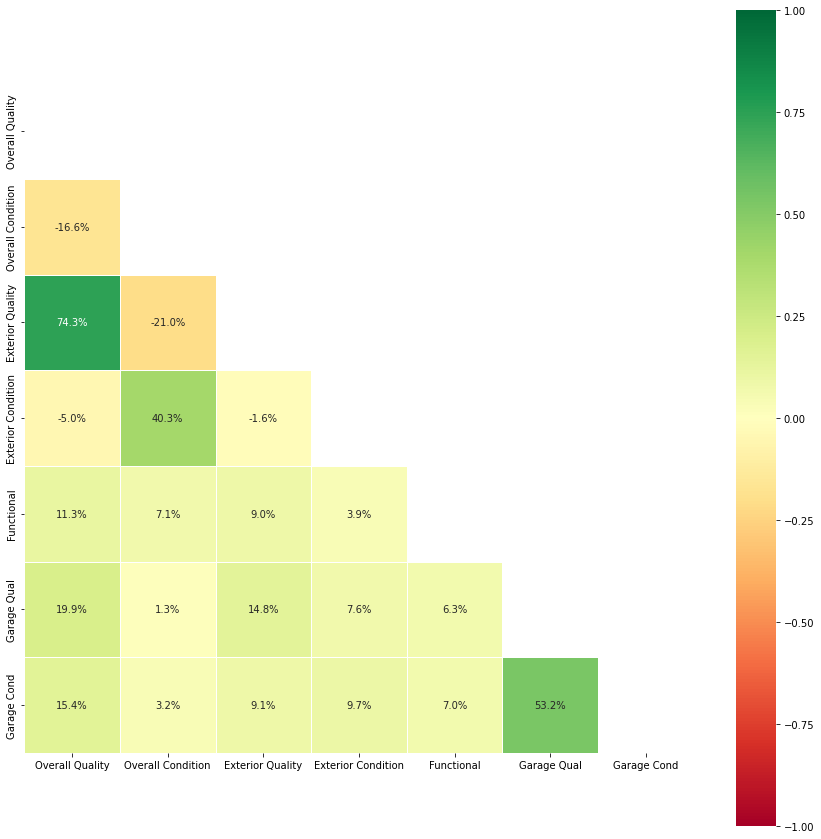

In [32]:
plot=plt.figure(figsize = (15,15))
mask = np.zeros_like(quality_condition_df.corr())
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(quality_condition_df.corr(), mask = mask, square = True, annot = True, fmt=".1%", vmin = -1, vmax = 1, linewidths = .5,cmap="RdYlGn")

We can see from the heatmap that the following factors are correlated:

- Overall Quality	and Exterior Quality 	

- Overall Condition and Exterior Condition	

- Garage Qual	and Garage Cond

So I will create interaction columns between these pairs.

## Feature Engineering Interaction Columns for Model 2

In [33]:
quality_condition_df['Overall_Exterior_Quality']=quality_condition_df['Overall Quality']*quality_condition_df['Exterior Quality']
quality_condition_df['Overall_Exterior_Condition']=quality_condition_df['Overall Condition']*quality_condition_df['Exterior Condition']
quality_condition_df['Garage_Qual_Condition']=quality_condition_df['Garage Qual']*quality_condition_df['Garage Cond']

In [34]:
quality_condition_df.head()

,Overall Quality,Overall Condition,Exterior Quality,Exterior Condition,Functional,Garage Qual,Garage Cond,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition
0,6,8,4,3,8,4,4,24,24,16
1,7,5,4,3,8,4,4,28,15,16
2,5,7,3,4,8,4,4,15,28,16
3,5,5,3,3,8,4,4,15,15,16
4,6,8,3,3,8,4,4,18,24,16


---

## Model 2

In [35]:
#X2 = quality_condition_df.drop(['Overall Quality','Overall Condition','Exterior Quality','Exterior Condition','Functional','Garage Qual','Garage Cond'], axis=1, inplace=True)
X2 = quality_condition_df[['Overall_Exterior_Quality','Overall_Exterior_Condition','Garage_Qual_Condition']]
y2 = price_factors_df

In [36]:
X2.head()

,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition
0,24,24,16
1,28,15,16
2,15,28,16
3,15,15,16
4,18,24,16


In [37]:
X2.shape

(1887, 3)

### Step 2: Instantiate the model

In [38]:
model2 = LinearRegression()

### Step 3: Fit the model

In [39]:
model2.fit(X2,y2)

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [40]:
for i in X2.columns:
    print (i)

Overall_Exterior_Quality
Overall_Exterior_Condition
Garage_Qual_Condition


In [41]:
model2.coef_

array([[ 0.62668415, -0.13721295,  0.14778937]])

In [42]:
model2_coef = dict(zip(X2.columns, model2.coef_[0]))


In [43]:
{k: v for k, v in sorted(model2_coef.items(), key=lambda item: item[1], reverse=True)}


{'Overall_Exterior_Quality': 0.6266841499905329,
 'Garage_Qual_Condition': 0.14778937326062114,
 'Overall_Exterior_Condition': -0.13721294914852733}

In [44]:
X2['Overall_Exterior_Quality'].value_counts(normalize=True)

15    0.248543
18    0.201378
28    0.152623
32    0.121887
21    0.071012
12    0.057234
24    0.056704
45    0.022258
36    0.018018
20    0.013249
50    0.011659
40    0.007419
9     0.005299
8     0.003180
10    0.002650
6     0.002650
16    0.001590
35    0.001590
27    0.000530
30    0.000530
Name: Overall_Exterior_Quality, dtype: float64

Interpretation of Coefficients

- Every increase in rating for Overall_Exterior_Quality has the effect of an increase in price per square feet by 0.626.
This is crucial as the maximum possible rating is 50. Which means a home could potentially have an increase by 31.3 per square foot.

### Step 5: Make predictions

In [45]:
X2.head(3)

,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition
0,24,24,16
1,28,15,16
2,15,28,16


In [46]:
y2_preds = model2.predict(X2)
y2_preds # y_preds are points on the regression plane 
# y_preds are the predicted riders data

array([[22.45806561],
       [26.19971876],
       [16.26905647],
       ...,
       [18.4867128 ],
       [16.17277236],
       [21.81292971]])

### Step 6: Evaluate the model

In [47]:
metrics.r2_score(y2, y2_preds)

0.17100769698946916

Only 17.1% of the data fall on the regression line. Terrible score.

In [48]:
metrics.mean_squared_error(y2, y2_preds) # the error is large

140.97488478315142

How is our model?

Our model isn't ideal. We will need to regularize.

## Regularization of Model 2

Referring to lesson 3.06

In [49]:
X2.head()

,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition
0,24,24,16
1,28,15,16
2,15,28,16
3,15,15,16
4,18,24,16


In [50]:
y2[:5]

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540


In [51]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X2,
    y2,
    test_size=0.25,
    random_state=42
) 

In [52]:
# Instantiate.
ridge_model2 = Ridge(alpha=10)

# Fit.
ridge_model2.fit(X_train, y_train)

# Best alpha
ridge_model2.alpha

10

In [53]:
# Instantiate.
ridge_model = Ridge(alpha=10)

# Fit.
ridge_model.fit(X_train, y_train)

# Evaluate model using R2.
print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))

0.18272609923251115
0.12616451067313694


The $R^2$ score increased marginally.

## USE PIPELINE [KIV]

---

# Factor 3: Parts of the Home

In [54]:
price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


In [55]:
price_factors_df['Price Per Sq Ft'].sort_values()

1492     1.324461
438      1.742138
880      2.504422
641      2.622689
684      2.797203
          ...    
376     83.845064
1122    84.067393
1389    87.294118
482     87.319666
1385    95.384615
Name: Price Per Sq Ft, Length: 1887, dtype: float64

In [56]:
parts_of_home_df.drop('Unnamed: 0', axis=1, inplace=True)
parts_of_home_df.head()


,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Garage Type,Garage Finish,Garage Cars,Paved Drive
0,2Story,Gable,CompShg,HdBoard,Plywood,CBlock,TA,TA,No,GLQ,Unf,0.0,0.0,2,1,3,1,Gd,6,0,Attchd,RFn,2.0,Y
1,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,Gd,TA,No,GLQ,Unf,1.0,0.0,2,1,4,1,Gd,8,1,Attchd,RFn,2.0,Y
2,1Story,Gable,CompShg,VinylSd,VinylSd,CBlock,TA,TA,No,GLQ,Unf,1.0,0.0,1,0,3,1,Gd,5,0,Detchd,Unf,1.0,Y
3,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,Gd,TA,No,Unf,Unf,0.0,0.0,2,1,3,1,TA,7,0,BuiltIn,Fin,2.0,Y
4,1.5Fin,Gable,CompShg,Wd Sdng,Plywood,PConc,Fa,Gd,No,Unf,Unf,0.0,0.0,2,0,3,1,TA,6,0,Detchd,Unf,2.0,N


---

## Data Dictionary

|Feature|Details|
|----|----|
|House Style (Nominal): |Style of dwelling|
|Roof Style (Nominal): |Type of roof|
|Roof Matl (Nominal): |Roof material|
|Exterior 1 (Nominal): |Exterior covering on house|
|Exterior 2 (Nominal): |Exterior covering on house (if more than one material)|
|Foundation (Nominal): |Type of foundation|
|Bsmt Qual (Ordinal): |Evaluates the height of the basement|
|Bsmt Cond (Ordinal): |Evaluates the general condition of the basement|
|Bsmt Exposure	(Ordinal): |Refers to walkout or garden level walls|
|BsmtFin Type 1	(Ordinal): |Rating of basement finished area|
|BsmtFinType 2	(Ordinal): |Rating of basement finished area (if multiple types)|
|Bsmt Full Bath (Discrete): |Basement full bathrooms|
|Bsmt Half Bath (Discrete): |Basement half bathrooms|
|Full Bath (Discrete): |Full bathrooms above grade|
|Half Bath (Discrete): |Half baths above grade|
|Bedroom (Discrete): |Bedrooms above grade (does NOT include basement bedrooms)|
|Kitchen (Discrete): |Kitchens above grade|
|KitchenQual (Ordinal): |Kitchen quality|
|TotRmsAbvGrd	(Discrete): |Total rooms above grade (does not include bathrooms)|
|Fireplaces (Discrete): |Number of fireplaces|
|Garage Type (Nominal): |Garage location|
|Garage Finish (Ordinal)	: |Interior finish of the garage|
|Garage Cars (Discrete): |Size of garage in car capacity|
|Paved Drive (Ordinal): |Paved driveway|


Ok there are a lot of factors here. Personally I will want to know how the following factors affect housing prices
- Roof Material
- Type of Foundation
- Basement Condition
- Basement Exposure
- BsmtFin
- Full Bath
- KitchenQual
- Total Rooms above Grade
- Paved Drive

I will do more feature engineering to modify the dataset.

---

## Feature Engineering for Model 3

In [57]:
parts_of_home_df.columns

Index(['House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Fireplaces', 'Garage Type',
       'Garage Finish', 'Garage Cars', 'Paved Drive'],
      dtype='object')

In [58]:
parts_of_home_df=parts_of_home_df[['Roof Matl','Foundation','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Full Bath','Kitchen Qual','TotRms AbvGrd','Paved Drive']]

In [59]:
parts_of_home_df.head()

,Roof Matl,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive
0,CompShg,CBlock,TA,No,GLQ,Unf,2,Gd,6,Y
1,CompShg,PConc,TA,No,GLQ,Unf,2,Gd,8,Y
2,CompShg,CBlock,TA,No,GLQ,Unf,1,Gd,5,Y
3,CompShg,PConc,TA,No,Unf,Unf,2,TA,7,Y
4,CompShg,PConc,Gd,No,Unf,Unf,2,TA,6,N


### Hot Encode Paved Drive Column

In [60]:
parts_of_home_df['Paved Drive'].value_counts()

Y    1765
N      88
P      34
Name: Paved Drive, dtype: int64

In [61]:
def paved(x):
    if x=='Y':
        x=2
    elif x=='P':
        x=1
    else:
        x=0
    return x

In [62]:
parts_of_home_df['Paved Drive'] = parts_of_home_df['Paved Drive'].map(paved)

### Hot Encode Bsmt Exposure Column

In [63]:
parts_of_home_df['Bsmt Exposure'].value_counts()

No    1258
Av     276
Gd     195
Mn     158
Name: Bsmt Exposure, dtype: int64

In [64]:
def bsmt_expose(x):
    if x=='Gd':
        x=4
    elif x=='Av':
        x=3
    elif x=='Mn':
        x=2
    elif x=='No':
        x=1
    else:
        x=0
    return x

In [65]:
parts_of_home_df['Bsmt Exposure']=parts_of_home_df['Bsmt Exposure'].map(bsmt_expose)

### Hot Encode Kitchen Qual and Bsmt Cond columns

In [66]:
parts_of_home_df['Kitchen Qual'].value_counts()

TA    927
Gd    782
Ex    149
Fa     29
Name: Kitchen Qual, dtype: int64

In [67]:
parts_of_home_df['Bsmt Cond'].value_counts()

TA    1745
Gd      84
Fa      53
Ex       3
Po       2
Name: Bsmt Cond, dtype: int64

I can use the ranking() function from Model 2

In [68]:
parts_of_home_df['Kitchen Qual'] = parts_of_home_df['Kitchen Qual'].map(ranking)
parts_of_home_df['Bsmt Cond'] = parts_of_home_df['Bsmt Cond'].map(ranking)

### Check Cleaned Data

In [69]:
parts_of_home_df.head(3)

,Roof Matl,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive
0,CompShg,CBlock,4,1,GLQ,Unf,2,5,6,2
1,CompShg,PConc,4,1,GLQ,Unf,2,5,8,2
2,CompShg,CBlock,4,1,GLQ,Unf,1,5,5,2


In [70]:
parts_of_home_df.corr()

,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive
Bsmt Cond,1.000000,0.104601,0.093170,0.146779,0.041544,0.099394
Bsmt Exposure,0.104601,1.000000,0.123451,0.291694,0.075823,0.109410
Full Bath,0.093170,0.123451,1.000000,0.439314,0.511321,0.149442
Kitchen Qual,0.146779,0.291694,0.439314,1.000000,0.311762,0.166647
TotRms AbvGrd,0.041544,0.075823,0.511321,0.311762,1.000000,0.072163
Paved Drive,0.099394,0.109410,0.149442,0.166647,0.072163,1.000000


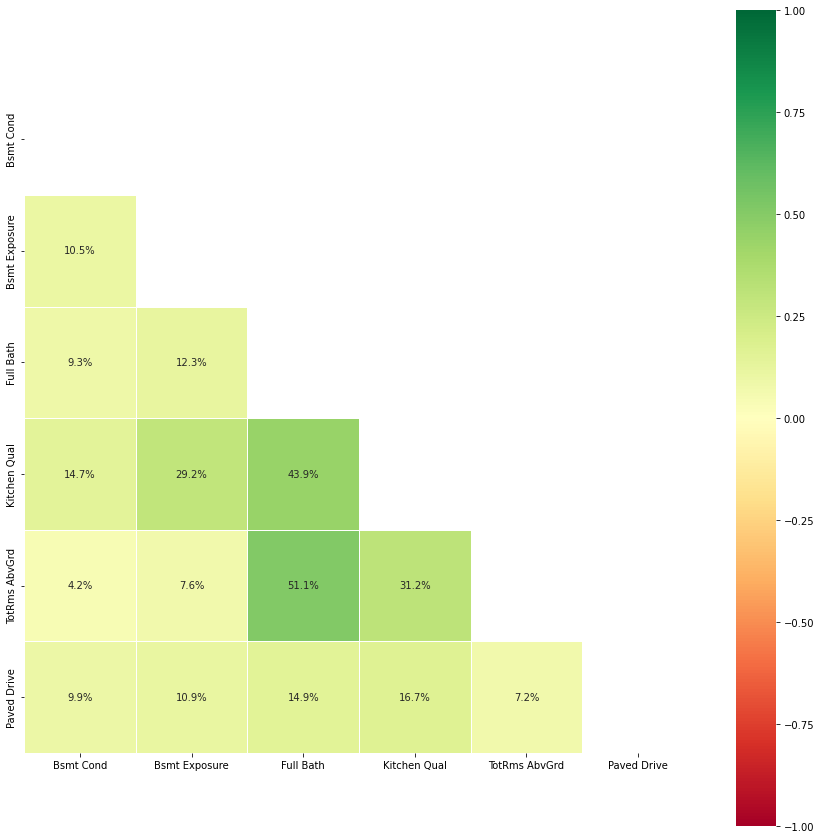

In [71]:
plot=plt.figure(figsize = (15,15))
mask = np.zeros_like(parts_of_home_df.corr())
mask[np.triu_indices_from(mask)] = True
ax=sns.heatmap(parts_of_home_df.corr(), mask = mask, square = True, annot = True, fmt=".1%", vmin = -1, vmax = 1, linewidths = .5,cmap="RdYlGn")

Strangely there are correlations between
Full Bath with Total Rooms above Ground and also with kitchen quality.

It makes no sense to create interaction columns, so I will not.

---

## Model 3

In [72]:
X3 = parts_of_home_df
y3 = price_factors_df

Create dummies for categorical data.

In [73]:
X3 = pd.get_dummies(drop_first=True, data=X3)
X3.head()

,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf
0,4,1,2,5,6,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,4,1,2,5,8,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,4,1,1,5,5,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,4,1,2,4,7,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,5,1,2,4,6,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


### Step 2: Instantiate the model

In [74]:
model3 = LinearRegression()

### Step 3: Fit the model

In [75]:
model3.fit(X3, y3) # X independent, y dependent

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [76]:
X3.columns

Index(['Bsmt Cond', 'Bsmt Exposure', 'Full Bath', 'Kitchen Qual',
       'TotRms AbvGrd', 'Paved Drive', 'Roof Matl_CompShg',
       'Roof Matl_Membran', 'Roof Matl_Tar&Grv', 'Roof Matl_WdShake',
       'Roof Matl_WdShngl', 'Foundation_CBlock', 'Foundation_PConc',
       'Foundation_Stone', 'Foundation_Wood', 'BsmtFin Type 1_BLQ',
       'BsmtFin Type 1_GLQ', 'BsmtFin Type 1_LwQ', 'BsmtFin Type 1_Rec',
       'BsmtFin Type 1_Unf', 'BsmtFin Type 2_BLQ', 'BsmtFin Type 2_GLQ',
       'BsmtFin Type 2_LwQ', 'BsmtFin Type 2_Rec', 'BsmtFin Type 2_Unf'],
      dtype='object')

In [77]:
model3.coef_

array([[ 0.26666147, -0.294036  ,  3.52695129,  3.75070428, -1.79071211,
         2.65803658, 20.93542449,  6.79300464, 15.05565883, 21.80537885,
        14.00653596, -0.9974695 ,  2.57959876,  3.84462883,  7.47338061,
        -2.37021238,  2.02781339, -1.79888985, -2.9564156 , -2.53623451,
        -1.32585776,  4.16563151,  1.18526815, -2.02195105,  1.39007266]])

In [78]:
model3_coef = dict(zip(X3.columns, model3.coef_[0]))
model3_coef

{'Bsmt Cond': 0.26666147024609815,
 'Bsmt Exposure': -0.2940360041229306,
 'Full Bath': 3.526951293017128,
 'Kitchen Qual': 3.7507042793420453,
 'TotRms AbvGrd': -1.7907121128183623,
 'Paved Drive': 2.65803657883321,
 'Roof Matl_CompShg': 20.93542448968444,
 'Roof Matl_Membran': 6.79300463651768,
 'Roof Matl_Tar&Grv': 15.055658829763722,
 'Roof Matl_WdShake': 21.80537885353543,
 'Roof Matl_WdShngl': 14.006535955538714,
 'Foundation_CBlock': -0.9974695047773943,
 'Foundation_PConc': 2.5795987565573397,
 'Foundation_Stone': 3.8446288326656233,
 'Foundation_Wood': 7.473380607980399,
 'BsmtFin Type 1_BLQ': -2.3702123763670335,
 'BsmtFin Type 1_GLQ': 2.02781339364228,
 'BsmtFin Type 1_LwQ': -1.7988898529457125,
 'BsmtFin Type 1_Rec': -2.956415597163659,
 'BsmtFin Type 1_Unf': -2.5362345064867835,
 'BsmtFin Type 2_BLQ': -1.3258577595598608,
 'BsmtFin Type 2_GLQ': 4.165631508974924,
 'BsmtFin Type 2_LwQ': 1.1852681500168514,
 'BsmtFin Type 2_Rec': -2.021951054425006,
 'BsmtFin Type 2_Unf': 1.

In [79]:
{k: v for k, v in sorted(model3_coef.items(), key=lambda item: item[1], reverse=True)}


{'Roof Matl_WdShake': 21.80537885353543,
 'Roof Matl_CompShg': 20.93542448968444,
 'Roof Matl_Tar&Grv': 15.055658829763722,
 'Roof Matl_WdShngl': 14.006535955538714,
 'Foundation_Wood': 7.473380607980399,
 'Roof Matl_Membran': 6.79300463651768,
 'BsmtFin Type 2_GLQ': 4.165631508974924,
 'Foundation_Stone': 3.8446288326656233,
 'Kitchen Qual': 3.7507042793420453,
 'Full Bath': 3.526951293017128,
 'Paved Drive': 2.65803657883321,
 'Foundation_PConc': 2.5795987565573397,
 'BsmtFin Type 1_GLQ': 2.02781339364228,
 'BsmtFin Type 2_Unf': 1.3900726565904622,
 'BsmtFin Type 2_LwQ': 1.1852681500168514,
 'Bsmt Cond': 0.26666147024609815,
 'Bsmt Exposure': -0.2940360041229306,
 'Foundation_CBlock': -0.9974695047773943,
 'BsmtFin Type 2_BLQ': -1.3258577595598608,
 'TotRms AbvGrd': -1.7907121128183623,
 'BsmtFin Type 1_LwQ': -1.7988898529457125,
 'BsmtFin Type 2_Rec': -2.021951054425006,
 'BsmtFin Type 1_BLQ': -2.3702123763670335,
 'BsmtFin Type 1_Unf': -2.5362345064867835,
 'BsmtFin Type 1_Rec': -2

#### Interpretation of coefficients


From the model, it appears that price is positively affected by the selection of the roof material.

- The effect of Wooden Shakes being the material of the roof results in an increase in price per square foot by 21.805

- Poor finish of the basement results in drop in price per square feet as is evident in the model.

### Step 5: Make predictions

In [80]:
X3.head()

,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf
0,4,1,2,5,6,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,4,1,2,5,8,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,4,1,1,5,5,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,4,1,2,4,7,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,5,1,2,4,6,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [81]:
y3_preds = model3.predict(X3)
y3_preds

array([[27.73845451],
       [27.73409854],
       [26.00221533],
       ...,
       [11.5220842 ],
       [15.27176544],
       [24.96076276]])

### Step 6: Evaluate the model

$R^2$

In [82]:
metrics.r2_score(y3, y3_preds)

0.2229226289068873

In [83]:
metrics.mean_squared_error(y3, y3_preds) # the error is HUGE

132.1464535431931

The $R^2$ is not good as only 22.3% of the data fall on the regression line.

Model 3 is not good so I will need to regularize.

## Regularization of Model 3

In [84]:
X3.head()

,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf
0,4,1,2,5,6,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,4,1,2,5,8,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,4,1,1,5,5,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
3,4,1,2,4,7,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,5,1,2,4,6,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [85]:
y3[:5]

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540


In [86]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X3,
    y3,
    test_size=0.25,
    random_state=42
) 

In [87]:
# Instantiate.
ridge_model3 = Ridge(alpha=10)

# Fit.
ridge_model3.fit(X_train, y_train)

# Best alpha
ridge_model3.alpha

10

In [88]:
# Instantiate.
ridge_model = Ridge(alpha=10)

# Fit.
ridge_model.fit(X_train, y_train)

# Evaluate model using R2.
print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))

0.23463759862785571
0.16288288838753684


The $R^2$ score increased marginally.

## USE PIPELINE [KIV]

---

# Factor 4: Utilities and Intangible Factors

In [89]:
price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


In [90]:
utilities_intangible_df.drop('Unnamed: 0', axis=1, inplace=True)
utilities_intangible_df.head(3)

,Heating,Heating QC,Central Air,Electrical,Utilities
0,GasA,Ex,Y,SBrkr,AllPub
1,GasA,Ex,Y,SBrkr,AllPub
2,GasA,TA,Y,SBrkr,AllPub


## Data Dictionary

|Column|Details|
|----|----|
|Heating	(Nominal): |Type of heating|
|HeatingQC (Ordinal): |Heating quality and condition|
|Central Air (Nominal): |Central air conditioning|
|Electrical (Ordinal): |Electrical system|
|Utilities (Ordinal): |Type of utilities available|


## Hot Encode Data

### Hot Encode Utilities Column

In [91]:
utilities_intangible_df['Utilities'].value_counts()

AllPub    1886
NoSeWa       1
Name: Utilities, dtype: int64

In [92]:
utilities_intangible_df['Utilities']=utilities_intangible_df['Utilities'].map({'AllPub':1, 'NoSeWa':0})

### Hot Encode Electrical Column

In [93]:
utilities_intangible_df['Electrical'].value_counts()

SBrkr    1747
FuseA     112
FuseF      23
FuseP       4
Mix         1
Name: Electrical, dtype: int64

In [94]:
def electric(x):
    if x=='SBrkr':
        x=4
    elif x=='FuseA':
        x=3
    elif x=='FuseF':
        x=2
    elif x=='FuseP':
        x=1
    else:
        x=0
    return x

In [95]:
utilities_intangible_df['Electrical']=utilities_intangible_df['Electrical'].map(electric)

### Hot Encode Central Air Column

In [96]:
utilities_intangible_df['Central Air']=utilities_intangible_df['Central Air'].map({'Y':1,'N':0})

In [97]:
utilities_intangible_df['Central Air'].value_counts()

1    1804
0      83
Name: Central Air, dtype: int64

### Heating Column

It is hard to rank which type of heating is better, so I will not hot encode this column

In [98]:
utilities_intangible_df['Heating'].value_counts()

GasA    1865
GasW      20
Grav       1
OthW       1
Name: Heating, dtype: int64

### Hot Encode Heating QC using ranking() function defined in Model 2

In [99]:
utilities_intangible_df['Heating QC'].value_counts()

Ex    1021
TA     524
Gd     292
Fa      48
Po       2
Name: Heating QC, dtype: int64

In [100]:
utilities_intangible_df['Heating QC']=utilities_intangible_df['Heating QC'].map(ranking)

### Check Cleaned Data Set

In [101]:
utilities_intangible_df.head(3)

,Heating,Heating QC,Central Air,Electrical,Utilities
0,GasA,6,1,4,1
1,GasA,6,1,4,1
2,GasA,4,1,4,1


## Model 4

In [102]:
X4 = utilities_intangible_df
y4 = price_factors_df

In [103]:
X4 = pd.get_dummies(drop_first=True, data=X4) 
X4.head()

,Heating QC,Central Air,Electrical,Utilities,Heating_GasW,Heating_Grav,Heating_OthW
0,6,1,4,1,0,0,0
1,6,1,4,1,0,0,0
2,4,1,4,1,0,0,0
3,5,1,4,1,0,0,0
4,4,1,4,1,0,0,0


### Step 2: Instantiate the model

In [104]:
model4 = LinearRegression()

### Step 3: Fit the model

In [105]:
model4.fit(X4, y4) # X independent, y dependent

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [106]:
model4.coef_


array([[ 2.76062143,  2.84015992,  3.54513902,  8.93938775, -3.41123481,
        -3.57505786, -0.19875804]])

In [107]:
model4_coef = dict(zip(X4.columns, model4.coef_[0]))
model4_coef


{'Heating QC': 2.7606214292450635,
 'Central Air': 2.8401599242591873,
 'Electrical': 3.545139018949784,
 'Utilities': 8.939387749833626,
 'Heating_GasW': -3.4112348137173436,
 'Heating_Grav': -3.575057859209738,
 'Heating_OthW': -0.19875804400519237}

In [108]:
{k: v for k, v in sorted(model4_coef.items(), key=lambda item: item[1], reverse=True)}


{'Utilities': 8.939387749833626,
 'Electrical': 3.545139018949784,
 'Central Air': 2.8401599242591873,
 'Heating QC': 2.7606214292450635,
 'Heating_OthW': -0.19875804400519237,
 'Heating_GasW': -3.4112348137173436,
 'Heating_Grav': -3.575057859209738}

#### Interpreting the Coefficients

- The type of utilities play a huge role in the price per square foor of the home. 

It is clear from this model that every factor is crucial and creates a positive effect on the price per square foot.

---

### Step 5: Make predictions

In [109]:
y4_preds = model4.predict(X4)
y4_preds

array([[24.81036559],
       [24.81036559],
       [19.28912273],
       ...,
       [22.04974416],
       [19.28912273],
       [22.04974416]])

### Step 6: Evaluate the model

In [110]:
metrics.r2_score(y4, y4_preds)

0.0689018010149749

In [111]:
metrics.mean_squared_error(y4, y4_preds) # the error is HUGE

158.3385766635354

The $R^2$ score is terrible

### Regularize Model 4

In [112]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(
    X4,
    y4,
    test_size=0.25,
    random_state=42
) 

In [113]:
# Instantiate.
ridge_model3 = Ridge(alpha=10)

# Fit.
ridge_model3.fit(X_train, y_train)

# Best alpha
ridge_model3.alpha

10

In [114]:
# Instantiate.
ridge_model = Ridge(alpha=10)

# Fit.
ridge_model.fit(X_train, y_train)

# Evaluate model using R2.
print(ridge_model.score(X_train, y_train))
print(ridge_model.score(X_test, y_test))

0.07233586347361909
0.0477177037486457


The improvement in $R^2$ score is marginal

### PIPELINE [KIV]

---

# Factor 5: Time Factors

In [115]:

price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


In [116]:
time_factors_df.drop('Unnamed: 0', axis=1, inplace=True)
time_factors_df

,Mo Sold,Yr Sold,Year Built,Year Remod/Add,Garage Yr Blt
0,3,2010,1976,2005,1976.0
1,4,2009,1996,1997,1997.0
2,1,2010,1953,2007,1953.0
3,4,2010,2006,2007,2007.0
4,3,2010,1900,1993,1957.0
...,...,...,...,...,...
1882,1,2008,2007,2007,2007.0
1883,3,2009,1940,1950,1961.0
1884,3,2009,1928,1950,1929.0
1885,11,2009,1956,1956,1956.0


### Feature Engineering: Age of Home Sold

In [117]:
time_factors_df['Built Age'] = time_factors_df['Yr Sold'] - time_factors_df['Year Built']

In [118]:
time_factors_df['Remod Age'] = time_factors_df['Yr Sold'] - time_factors_df['Year Remod/Add']

In [119]:
time_factors_df.head(3)

,Mo Sold,Yr Sold,Year Built,Year Remod/Add,Garage Yr Blt,Built Age,Remod Age
0,3,2010,1976,2005,1976.0,34,5
1,4,2009,1996,1997,1997.0,13,12
2,1,2010,1953,2007,1953.0,57,3


### Scale Engineered Feature

I will need to scale the data 

Reminder to self: Refer to Lecture 3.05 Feature Engineering

In [120]:
X5 = time_factors_df.drop(['Mo Sold','Yr Sold','Year Built','Year Remod/Add','Garage Yr Blt'], axis=1)
y5 = price_factors_df

In [121]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [122]:
ss = StandardScaler() # instantiate the standard scaler class
ss.fit(X5)
X5_scaled = ss.transform(X5)
X5_scaled

array([[-2.16940873e-04, -8.51199672e-01],
       [-7.16609938e-01, -5.11527261e-01],
       [ 7.84403961e-01, -9.48248932e-01],
       ...,
       [ 1.60313881e+00,  1.76913035e+00],
       [ 6.47948152e-01,  1.47798257e+00],
       [-7.84837842e-01, -5.60051892e-01]])

---

## Model 5

In [123]:
X5 = pd.get_dummies(drop_first=True, data=X5)
# this is actually unnecessary

In [124]:
X5.head()

,Built Age,Remod Age
0,34,5
1,13,12
2,57,3
3,4,3
4,110,17


### Step 2: Instantiate the model

In [125]:
model5 = LinearRegression()

### Step 3: Fit the model

In [126]:
model5.fit(X5, y5) # X independent, y dependent

LinearRegression()

### Step 4: Check out and interpret our coefficients

In [127]:
model5.coef_


array([[-0.12680071, -0.09558967]])

In [128]:
model5_coef = dict(zip(X5.columns, model5.coef_[0]))
model5_coef


{'Built Age': -0.12680070868533594, 'Remod Age': -0.09558966544856497}

In [129]:
{k: v for k, v in sorted(model5_coef.items(), key=lambda item: item[1], reverse=True)}


{'Remod Age': -0.09558966544856497, 'Built Age': -0.12680070868533594}

#### Interpreting Coefficients

It makes sense that the price per square foot will decrease as the age increases, which can be seen from the coefficients.

### Step 5: Make predictions

In [130]:
y5_preds = model5.predict(X5)
y5_preds # y_preds are points on the regression plane 

array([[23.81050475],
       [25.80419197],
       [21.08526778],
       ...,
       [12.6890295 ],
       [16.81298734],
       [26.15338305]])

### Step 6: Evaluate the model

In [131]:
# R2:
metrics.r2_score(y5, y5_preds)

0.1603759302885206

In [132]:
metrics.mean_squared_error(y5, y5_preds) # the error is HUGE

142.78287754769767

$R^2$ score is not good as only 16% of the points fall on the regression line.

Initially my coefficients were too huge!
But Chee Yong gave me the solution.
UPDATE: Settled. I cannot mix dates with age. 

---

In [133]:
price_factors_df

,Price Per Sq Ft
0,9.654509
1,19.143752
2,13.759152
3,17.751479
4,9.729540
...,...
1882,26.094069
1883,6.684492
1884,23.418894
1885,13.846154


#

# Overall Model 


Merge All Smaller Cleaned Dataframes to create a holistic model

## Step 1: Merge Datasets

In [134]:
df_merged = X.join(X2, how='outer')

In [135]:
df_merged = df_merged.join(X3, how='outer')

In [136]:
df_merged = df_merged.join(X4, how='outer')

In [137]:
df_merged = df_merged.join(X5, how='outer')

In [138]:
df_merged.head()

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating QC,Central Air,Electrical,Utilities,Heating_GasW,Heating_Grav,Heating_OthW,Built Age,Remod Age
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,24,24,16,4,1,2,5,6,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,6,1,4,1,0,0,0,34,5
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,4,1,2,5,8,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,6,1,4,1,0,0,0,13,12
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,15,28,16,4,1,1,5,5,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,4,1,4,1,0,0,0,57,3
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,15,15,16,4,1,2,4,7,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,5,1,4,1,0,0,0,4,3
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,18,24,16,5,1,2,4,6,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,4,1,4,1,0,0,0,110,17


## Step 2: Instantiate the Model

In [139]:
model_merge = LinearRegression()

## Step 3: Fit the Model

In [140]:
model_merge.fit(df_merged, y)

LinearRegression()

## Step 4: Check out and interpret our coefficients

In [141]:
model_merge.coef_

array([-6.63564065e-01,  1.32233911e+01, -2.41314032e-01,  1.07326725e+00,
        4.24988980e+01,  1.85400994e+00,  2.03325153e-01,  2.86033113e+00,
        2.16299206e+01,  2.31439570e-01,  2.19434951e-01, -2.29462215e-01,
        1.52828632e+01, -1.56374753e+00, -9.73659469e-01,  6.12975292e+00,
        5.25088440e-02,  1.03211184e+00,  3.79814468e+00, -1.64436435e-01,
       -2.22326756e+00, -6.02884873e+00,  1.34151505e+00,  1.78113331e+00,
        1.52064812e+00,  8.59319773e-01,  4.03923572e+00, -2.56504727e+00,
       -5.43831051e-01,  1.12669262e+00,  1.59701336e+00,  1.98475527e+00,
        1.25611008e-01, -1.77451724e+00, -4.27405295e+00, -4.64631505e+00,
       -9.27340617e-01, -2.44475467e+00, -1.18320688e+00,  2.19434951e-01,
        1.90527346e+01,  5.53406237e+00,  2.88333706e+00, -4.30637359e+00,
        5.38768326e-01,  1.77070995e+00, -2.81253564e+00,  2.13436040e+00,
       -5.06917681e+00, -6.89027609e+00,  1.76448606e+00,  3.02868337e-01,
        9.26375874e-02, -

In [142]:
df_merged.columns

Index(['MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD',
       'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished',
       'MS SubClass_1.5 Storey PUD', 'MS SubClass_1.5 Unfinished',
       'MS SubClass_2 Storey 1946 Newer', 'MS SubClass_2 Storey 1946 Older',
       'MS SubClass_2 Storey PUD', 'MS SubClass_2.5 Story All',
       'MS SubClass_Duplex All', 'MS SubClass_Family Conversion',
       'MS SubClass_PUD Multi', 'MS SubClass_Split', 'MS SubClass_Split Foyer',
       'MS Zoning_Floating Village Residential',
       'MS Zoning_Residential High Density',
       'MS Zoning_Residential Low Density',
       'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA',
       'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn',
       'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Feedr',
       'Condition 2_Norm', 

In [143]:
coef_dict = dict(zip(df_merged.columns, model_merge.coef_))
coef_dict

{'MS SubClass_1 Storey Newer All': -0.6635640652501008,
 'MS SubClass_1 Storey PUD': 13.223391144455382,
 'MS SubClass_1 Storey W/Finished Attic': -0.2413140319752487,
 'MS SubClass_1.5 Finished': 1.073267253387482,
 'MS SubClass_1.5 Storey PUD': 42.49889799224564,
 'MS SubClass_1.5 Unfinished': 1.8540099404232775,
 'MS SubClass_2 Storey 1946 Newer': 0.2033251525536901,
 'MS SubClass_2 Storey 1946 Older': 2.860331129700092,
 'MS SubClass_2 Storey PUD': 21.629920574480156,
 'MS SubClass_2.5 Story All': 0.23143956968568613,
 'MS SubClass_Duplex All': 0.21943495139711366,
 'MS SubClass_Family Conversion': -0.2294622146277545,
 'MS SubClass_PUD Multi': 15.282863245280451,
 'MS SubClass_Split': -1.5637475343185372,
 'MS SubClass_Split Foyer': -0.9736594686397115,
 'MS Zoning_Floating Village Residential': 6.1297529240033075,
 'MS Zoning_Residential High Density': 0.05250884395864297,
 'MS Zoning_Residential Low Density': 1.0321118423662536,
 'MS Zoning_Residential Medium Density': 3.7981446

## Sort Coefficient Dictionary based on Coefficient Strength

In [144]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}


{'Lot Shape_IR3': -6.8902760932362295,
 'Lot Config_FR3': -6.0288487261111765,
 'Lot Shape_IR2': -5.069176807709791,
 'Heating_Grav': -4.941892177530597,
 'Condition 2_RRAe': -4.646315046297456,
 'Land Contour_Low': -4.3063735945895925,
 'Condition 2_PosN': -4.274052954651163,
 'Heating_OthW': -3.7917640102093815,
 'Heating_GasW': -2.873398841902832,
 'Land Slope_Sev': -2.8125356364709355,
 'BsmtFin Type 1_Unf': -2.5997023261287993,
 'Condition 1_RRAe': -2.565047269208801,
 'Condition 2_RRNn': -2.444754671488532,
 'Lot Config_FR2': -2.223267555849238,
 'Condition 2_PosA': -1.774517238910934,
 'BsmtFin Type 1_Rec': -1.5761065681984574,
 'MS SubClass_Split': -1.5637475343185372,
 'Foundation_CBlock': -1.4234293137229983,
 'Bldg Type_2fmCon': -1.1832068818603307,
 'BsmtFin Type 1_BLQ': -0.9850474040544301,
 'MS SubClass_Split Foyer': -0.9736594686397115,
 'Condition 2_RRAn': -0.9273406166743852,
 'BsmtFin Type 2_BLQ': -0.853630668308603,
 'BsmtFin Type 2_Rec': -0.6935458126929217,
 'MS Su

I will discuss the effects of the coefficients in the Conclusion section.

## Step 5: Make Predictions

In [145]:
merge_preds = model_merge.predict(df_merged)
merge_preds

array([14.55772496, 21.35218749, 16.62113448, ..., 16.39616072,
       11.87498426, 20.0086837 ])

## Step 6: Evaluate the model

In [146]:
metrics.r2_score(y, merge_preds)

0.7790249032270138

In [147]:
metrics.mean_squared_error(y, merge_preds) # the error is HUGE

37.57807966899993

The $R^2$ score is decent at 77.9% accuracy

---

# Apply Overall Model to Test Dataset

## Import test.csv

In [148]:
test_file = 'test_clean.csv'
test_df = pd.read_csv(test_file)
test_df.drop('Unnamed: 0', axis=1, inplace=True)

## Cleaned Test Data

In [149]:
print(test_df.shape)
test_df.head(2)

(878, 67)


,Id,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_I (all),MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Roof Matl,Foundation,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Heating,Heating QC,Central Air,Electrical,Utilities,Built Age,Remod Age
0,2658,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,18,16,4,CompShg,Stone,4,1,Unf,Unf,2,3,9,2,GasA,5,0,1,1.0,96,56
1,2718,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,15,12,16,CompShg,CBlock,4,1,Unf,Unf,2,4,10,2,GasA,4,1,4,1.0,29,29


In [150]:
print(df_merged.shape)
df_merged.head(2)

(1887, 88)


,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Storey PUD,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Roof Matl_CompShg,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Foundation_CBlock,Foundation_PConc,Foundation_Stone,Foundation_Wood,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Heating QC,Central Air,Electrical,Utilities,Heating_GasW,Heating_Grav,Heating_OthW,Built Age,Remod Age
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,24,24,16,4,1,2,5,6,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,6,1,4,1,0,0,0,34,5
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,4,1,2,5,8,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,6,1,4,1,0,0,0,13,12


In [151]:
test_df.columns

Index(['Id', 'MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD',
       'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished',
       'MS SubClass_1.5 Unfinished', 'MS SubClass_2 Storey 1946 Newer',
       'MS SubClass_2 Storey 1946 Older', 'MS SubClass_2 Storey PUD',
       'MS SubClass_2.5 Story All', 'MS SubClass_Duplex All',
       'MS SubClass_Family Conversion', 'MS SubClass_PUD Multi',
       'MS SubClass_Split', 'MS SubClass_Split Foyer',
       'MS Zoning_Floating Village Residential', 'MS Zoning_I (all)',
       'MS Zoning_Residential High Density',
       'MS Zoning_Residential Low Density',
       'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA',
       'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn',
       'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Norm',
       'Condition 2_PosA', 'Bld

In [152]:
df_merged.columns

Index(['MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD',
       'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished',
       'MS SubClass_1.5 Storey PUD', 'MS SubClass_1.5 Unfinished',
       'MS SubClass_2 Storey 1946 Newer', 'MS SubClass_2 Storey 1946 Older',
       'MS SubClass_2 Storey PUD', 'MS SubClass_2.5 Story All',
       'MS SubClass_Duplex All', 'MS SubClass_Family Conversion',
       'MS SubClass_PUD Multi', 'MS SubClass_Split', 'MS SubClass_Split Foyer',
       'MS Zoning_Floating Village Residential',
       'MS Zoning_Residential High Density',
       'MS Zoning_Residential Low Density',
       'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA',
       'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn',
       'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Feedr',
       'Condition 2_Norm', 

In [153]:
intersect_ = []
for i in test_df.columns:
    if i in df_merged.columns:
        intersect_.append(i)
print(len(intersect_))
intersect_

60


['MS SubClass_1 Storey Newer All',
 'MS SubClass_1 Storey PUD',
 'MS SubClass_1 Storey W/Finished Attic',
 'MS SubClass_1.5 Finished',
 'MS SubClass_1.5 Unfinished',
 'MS SubClass_2 Storey 1946 Newer',
 'MS SubClass_2 Storey 1946 Older',
 'MS SubClass_2 Storey PUD',
 'MS SubClass_2.5 Story All',
 'MS SubClass_Duplex All',
 'MS SubClass_Family Conversion',
 'MS SubClass_PUD Multi',
 'MS SubClass_Split',
 'MS SubClass_Split Foyer',
 'MS Zoning_Floating Village Residential',
 'MS Zoning_Residential High Density',
 'MS Zoning_Residential Low Density',
 'MS Zoning_Residential Medium Density',
 'Lot Config_CulDSac',
 'Lot Config_FR2',
 'Lot Config_FR3',
 'Lot Config_Inside',
 'Condition 1_Feedr',
 'Condition 1_Norm',
 'Condition 1_PosA',
 'Condition 1_PosN',
 'Condition 1_RRAe',
 'Condition 1_RRAn',
 'Condition 1_RRNe',
 'Condition 1_RRNn',
 'Condition 2_Norm',
 'Condition 2_PosA',
 'Bldg Type_2fmCon',
 'Bldg Type_Duplex',
 'Bldg Type_Twnhs',
 'Bldg Type_TwnhsE',
 'Land Contour_HLS',
 'Land 

In [154]:
test_df = test_df[intersect_]

In [155]:
test_df.dropna()

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Heating QC,Central Air,Electrical,Utilities,Built Age,Remod Age
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,18,16,4,4,1,2,3,9,2,5,0,1,1.0,96,56
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,15,12,16,4,1,2,4,10,2,4,1,4,1.0,29,29
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,5,3,2,5,7,2,6,1,4,1.0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,20,18,12,4,1,1,4,5,0,4,1,4,1.0,84,1
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,18,15,16,4,1,1,4,6,2,5,1,4,1.0,46,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,18,18,16,4,1,2,4,8,2,4,1,4,1.0,33,33
874,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,24,28,16,4,1,2,5,9,2,6,1,4,1.0,42,9
875,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,15,15,16,4,1,1,4,5,2,6,1,4,1.0,40,40
876,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,12,18,16,4,1,1,4,5,2,4,1,4,1.0,36,36


In [156]:
np.any(np.isnan(test_df))

True

In [157]:
test_df=test_df.dropna()

## The Model Predictions for Test Data

In [158]:
# test_preds = model_merge.predict(test_df)

## Remodel

Keep getting "ValueError: X has 60 features, but LinearRegression is expecting 88 features as input."

In [159]:
df_merged=df_merged[intersect_]

In [160]:
model_merge2 = LinearRegression()

In [161]:
model_merge2.fit(df_merged, y)

LinearRegression()

In [162]:
model_merge2.coef_

array([-2.47621113e+00,  3.57799711e+00,  2.73401459e-01, -1.79639446e-02,
        4.62379541e-01, -1.66720081e+00,  2.05946725e+00,  1.12298158e+01,
       -7.76264753e-01, -8.67130551e-01, -3.44364231e+00,  5.33467662e+00,
       -3.42096934e+00, -2.17804334e+00,  6.11763801e+00,  2.51725935e-01,
        9.30604677e-01,  3.62684068e+00, -1.11650543e-01, -2.16249595e+00,
       -5.24984761e+00,  1.27180095e+00,  1.56974154e+00,  1.74111020e+00,
        2.13376538e-01,  3.82929261e+00, -2.00455093e+00, -1.17112861e-01,
        8.99726347e-01,  1.75270807e+00,  4.99680549e-01, -1.13883527e+00,
        7.22469576e-01, -8.67130551e-01,  2.81963681e+01,  1.38822427e+01,
        3.69941211e+00, -4.07373868e+00,  6.82943534e-01,  1.69717768e+00,
       -3.77995535e+00,  2.46407597e+00, -4.92835685e+00, -8.88527268e+00,
        1.76120387e+00,  2.82122656e-01,  1.00969312e-01, -3.69249638e-03,
        5.12788205e-01,  4.77109306e-01,  5.16537515e-01,  7.12986441e-01,
        2.67158778e-01,  

In [163]:
merge2_preds = model_merge2.predict(df_merged)
merge2_preds

array([14.85012817, 20.39223632, 16.1213709 , ..., 16.33101064,
       11.73893886, 21.08452533])

In [164]:
metrics.r2_score(y, merge2_preds)

0.7667250047893925

Score is still good in spite of variable reduction

## Apply Model To Test Dataset

In [165]:
test_preds = model_merge2.predict(test_df)

In [166]:
print(test_preds)

[15.57780029 15.77454399 23.85720936 17.01735823 13.7585568  44.36501042
 16.64425877 16.54958529 54.63545757 17.03947777 40.24827882 18.17821971
 15.17273975 21.90495672 16.67262335 11.74129791 17.61923286 13.69384235
 14.99534285 21.70887075 16.90587195 11.7006438  40.59649657  4.7448736
 21.451938   14.56066424  9.58530042 14.00402556 19.36828502  9.69376561
 12.19001095 16.24479432 16.48006487 16.57119257 23.00087149 18.23550127
 12.26634527  8.67582153 16.82002054 25.69690643 53.87014972 21.04913217
 15.16913899 16.90555756 40.86176438 59.48643526 22.13208589 13.06738496
 15.16399651 12.22664154 18.11012174 24.63814926 23.59496707 19.21414957
 16.24394618 17.80896645 16.39129727 14.49468421 13.74222685 21.83872742
 22.44024    10.31284019 14.04863517 16.78345533 22.56268088 21.26090768
 10.70756724 56.24445016 16.21842674 44.41701015 13.30384582 15.5807816
 12.25553906 15.77991624 14.40322402 12.39023566 12.36505789 16.32426541
 10.25097083 27.12639556 22.73056536 21.05056779 22.3

In [167]:
print(len(test_preds))

877


The test predictions are in price per square meters

For submission onto Kaggle, I need to output SalePrice

# Remodel Based on Sale Price [Kaggle Submission]

The reason is that the original model is applied to Price per Square Feet. Kaggle requires price projection.

In [168]:
df_merged.head()

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Heating QC,Central Air,Electrical,Utilities,Built Age,Remod Age
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,24,24,16,4,1,2,5,6,2,6,1,4,1,34,5
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,4,1,2,5,8,2,6,1,4,1,13,12
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,15,28,16,4,1,1,5,5,2,4,1,4,1,57,3
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,15,15,16,4,1,2,4,7,2,5,1,4,1,4,3
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,18,24,16,5,1,2,4,6,0,4,1,4,1,110,17


In [169]:
price_factors_df=pd.read_csv('price_factors.csv')
SalePrice = price_factors_df['SalePrice']
SalePrice

0       130500
1       220000
2       109000
3       174000
4       138500
         ...  
1882    298751
1883     82500
1884    177000
1885    144000
1886    189000
Name: SalePrice, Length: 1887, dtype: int64

In [170]:
price_model = LinearRegression()

In [171]:
price_model.fit(df_merged,SalePrice)

LinearRegression()

In [172]:
price_model.coef_

array([  -760.95267615,  -5835.0639437 ,  -3640.10338442,  -5978.25280415,
       -12271.62379843, -10130.48794144,  -9299.99512863, -13890.58985675,
        15488.32519414, -13411.12844197, -32958.14004687,  -2793.55612422,
       -23587.999102  , -13129.41285185,  18414.71634928,  28761.58715591,
        19636.678012  ,  11958.14218273,  14758.30114972,  -6330.99266975,
         -263.98304997,  -1139.92913419,   7037.04317588,  12143.7192983 ,
        35712.83461548,  29683.54863223,  -9077.21826475,   -692.86533601,
       -23631.17238446, -13067.45417156,  -6361.52028918, -34427.58483548,
        21112.28269893, -13411.12844197, -20663.66481239, -14508.95667224,
        23671.01534892,  22402.487468  ,  10190.01774087,  13720.6596453 ,
        17394.18746355,   9237.7466557 ,   4113.57407387, -25840.21961333,
        -1562.44713096,   4863.65070791,    642.35945543,   1880.54838037,
         2298.09171201,   9448.82693037,   9901.52334913,  12997.06357075,
        12632.71333451,  

In [173]:
price_pred = price_model.predict(df_merged)
price_pred

array([191833.13502804, 255403.48551066, 138672.52664231, ...,
       155870.37423487, 120474.47412779, 191873.87207989])

In [174]:
metrics.r2_score(SalePrice, price_pred)

0.7964545693896767

79.6% accuracy. Good score.

## Apply new model to Test Data

In [175]:
test_data_with_id = pd.read_csv('test_clean_Id.csv')

In [176]:
test_data_with_id.set_index('Id', inplace=True)
test_data_with_id = test_data_with_id[intersect_]
print(test_data_with_id.shape)
test_data_with_id.head()

(878, 60)


,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Heating QC,Central Air,Electrical,Utilities,Built Age,Remod Age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2658,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,18,16,4,4,1,2,3,9,2,5,0,1,1.0,96,56
2718,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,15,12,16,4,1,2,4,10,2,4,1,4,1.0,29,29
2414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,5,3,2,5,7,2,6,1,4,1.0,0,0
1989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,20,18,12,4,1,1,4,5,0,4,1,4,1.0,84,1
625,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,18,15,16,4,1,1,4,6,2,5,1,4,1.0,46,46


In [177]:
# test_data_with_id = test_data_with_id.dropna()

In [178]:
test_data_with_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 878 entries, 2658 to 1939
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   MS SubClass_1 Storey Newer All          878 non-null    int64  
 1   MS SubClass_1 Storey PUD                878 non-null    int64  
 2   MS SubClass_1 Storey W/Finished Attic   878 non-null    int64  
 3   MS SubClass_1.5 Finished                878 non-null    int64  
 4   MS SubClass_1.5 Unfinished              878 non-null    int64  
 5   MS SubClass_2 Storey 1946 Newer         878 non-null    int64  
 6   MS SubClass_2 Storey 1946 Older         878 non-null    int64  
 7   MS SubClass_2 Storey PUD                878 non-null    int64  
 8   MS SubClass_2.5 Story All               878 non-null    int64  
 9   MS SubClass_Duplex All                  878 non-null    int64  
 10  MS SubClass_Family Conversion           878 non-null    in

In [179]:
test_data_with_id.isna().any()

MS SubClass_1 Storey Newer All            False
MS SubClass_1 Storey PUD                  False
MS SubClass_1 Storey W/Finished Attic     False
MS SubClass_1.5 Finished                  False
MS SubClass_1.5 Unfinished                False
MS SubClass_2 Storey 1946 Newer           False
MS SubClass_2 Storey 1946 Older           False
MS SubClass_2 Storey PUD                  False
MS SubClass_2.5 Story All                 False
MS SubClass_Duplex All                    False
MS SubClass_Family Conversion             False
MS SubClass_PUD Multi                     False
MS SubClass_Split                         False
MS SubClass_Split Foyer                   False
MS Zoning_Floating Village Residential    False
MS Zoning_Residential High Density        False
MS Zoning_Residential Low Density         False
MS Zoning_Residential Medium Density      False
Lot Config_CulDSac                        False
Lot Config_FR2                            False
Lot Config_FR3                          

In [180]:
test_data_with_id['Utilities']=test_data_with_id['Utilities'].fillna(test_data_with_id['Utilities'].mean())

In [181]:
test_pred2 = price_model.predict(test_data_with_id)

In [182]:
test_pred2

array([128106.9449569 , 169647.85800758, 249065.92925529, 120166.6328528 ,
       150181.21928062,  74384.23012216,  97891.96901933, 191204.29262638,
       155856.88305172, 161917.97729883, 170699.8782524 , 126848.76928502,
       135158.92524874, 189258.96312598, 148116.33321061, 113777.47793964,
       165092.73419291, 122011.56392285, 182372.39471594, 225830.08643267,
       166593.98594952, 120376.73824173, 170233.53928227, 176185.43066394,
       216067.04932986, 146822.48458983, 117356.30121368, 121662.21110316,
       180368.2028272 ,  10265.94662739,  98774.08690457,  96581.99955476,
       194098.9808775 , 135264.70828759, 231921.41219733, 168215.64879116,
        96957.56480293,  54191.52137857, 179026.72510566, 210112.17208542,
       169501.55646109, 266666.24794444, 159649.64257158, 157603.03637226,
       211786.02352753,  48110.92259878, 224117.63539966, 144650.14156368,
       108646.26934771, 118153.17036101, 105106.82303121, 238734.99424263,
       275520.47898828, 1

In [183]:
test_data_with_id['SalePrice'] = test_pred2

In [184]:
test_data_with_id.head()

,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Heating QC,Central Air,Electrical,Utilities,Built Age,Remod Age,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2658,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,18,16,4,4,1,2,3,9,2,5,0,1,1.0,96,56,128106.944957
2718,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,15,12,16,4,1,2,4,10,2,4,1,4,1.0,29,29,169647.858008
2414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,5,3,2,5,7,2,6,1,4,1.0,0,0,249065.929255
1989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,20,18,12,4,1,1,4,5,0,4,1,4,1.0,84,1,120166.632853
625,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,18,15,16,4,1,1,4,6,2,5,1,4,1.0,46,46,150181.219281


In [185]:
test_data_with_id.reset_index()

,Id,MS SubClass_1 Storey Newer All,MS SubClass_1 Storey PUD,MS SubClass_1 Storey W/Finished Attic,MS SubClass_1.5 Finished,MS SubClass_1.5 Unfinished,MS SubClass_2 Storey 1946 Newer,MS SubClass_2 Storey 1946 Older,MS SubClass_2 Storey PUD,MS SubClass_2.5 Story All,MS SubClass_Duplex All,MS SubClass_Family Conversion,MS SubClass_PUD Multi,MS SubClass_Split,MS SubClass_Split Foyer,MS Zoning_Floating Village Residential,MS Zoning_Residential High Density,MS Zoning_Residential Low Density,MS Zoning_Residential Medium Density,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Norm,Condition 2_PosA,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Land Slope_Mod,Land Slope_Sev,Street_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Overall_Exterior_Quality,Overall_Exterior_Condition,Garage_Qual_Condition,Bsmt Cond,Bsmt Exposure,Full Bath,Kitchen Qual,TotRms AbvGrd,Paved Drive,Heating QC,Central Air,Electrical,Utilities,Built Age,Remod Age,SalePrice
0,2658,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,18,16,4,4,1,2,3,9,2,5,0,1,1.0,96,56,128106.944957
1,2718,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,15,12,16,4,1,2,4,10,2,4,1,4,1.0,29,29,169647.858008
2,2414,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,28,15,16,5,3,2,5,7,2,6,1,4,1.0,0,0,249065.929255
3,1989,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,20,18,12,4,1,1,4,5,0,4,1,4,1.0,84,1,120166.632853
4,625,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,18,15,16,4,1,1,4,6,2,5,1,4,1.0,46,46,150181.219281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,18,18,16,4,1,2,4,8,2,4,1,4,1.0,33,33,195210.704733
874,1234,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,24,28,16,4,1,2,5,9,2,6,1,4,1.0,42,9,235216.258525
875,1373,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,15,15,16,4,1,1,4,5,2,6,1,4,1.0,40,40,116319.256826
876,1672,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,12,18,16,4,1,1,4,5,2,4,1,4,1.0,36,36,104653.289573


In [186]:
test_data_with_id.columns

Index(['MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD',
       'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished',
       'MS SubClass_1.5 Unfinished', 'MS SubClass_2 Storey 1946 Newer',
       'MS SubClass_2 Storey 1946 Older', 'MS SubClass_2 Storey PUD',
       'MS SubClass_2.5 Story All', 'MS SubClass_Duplex All',
       'MS SubClass_Family Conversion', 'MS SubClass_PUD Multi',
       'MS SubClass_Split', 'MS SubClass_Split Foyer',
       'MS Zoning_Floating Village Residential',
       'MS Zoning_Residential High Density',
       'MS Zoning_Residential Low Density',
       'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac',
       'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside',
       'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA',
       'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn',
       'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Norm',
       'Condition 2_PosA', 'Bldg Type_2fmCon', 'Bldg Type_

In [187]:
test_data_with_id = test_data_with_id[['SalePrice']]

In [188]:
test_data_with_id.head(2)

,SalePrice
Id,
2658,128106.944957
2718,169647.858008


In [189]:
test_data_with_id.to_csv('kaggle_joel_quek_regression_challenge.csv')

Initially I received this "Evaluation Exception: Submission must have 878 rows"

I realised that NaN did not have to be removed.

These are my predictions which I will upload to Kaggle

My Kaggle Score is 33424.09674 (RMSE)

---

# Conclusions and Findings

## Finding Undervalued Homes

In [190]:
print(len(merge_preds))

1887


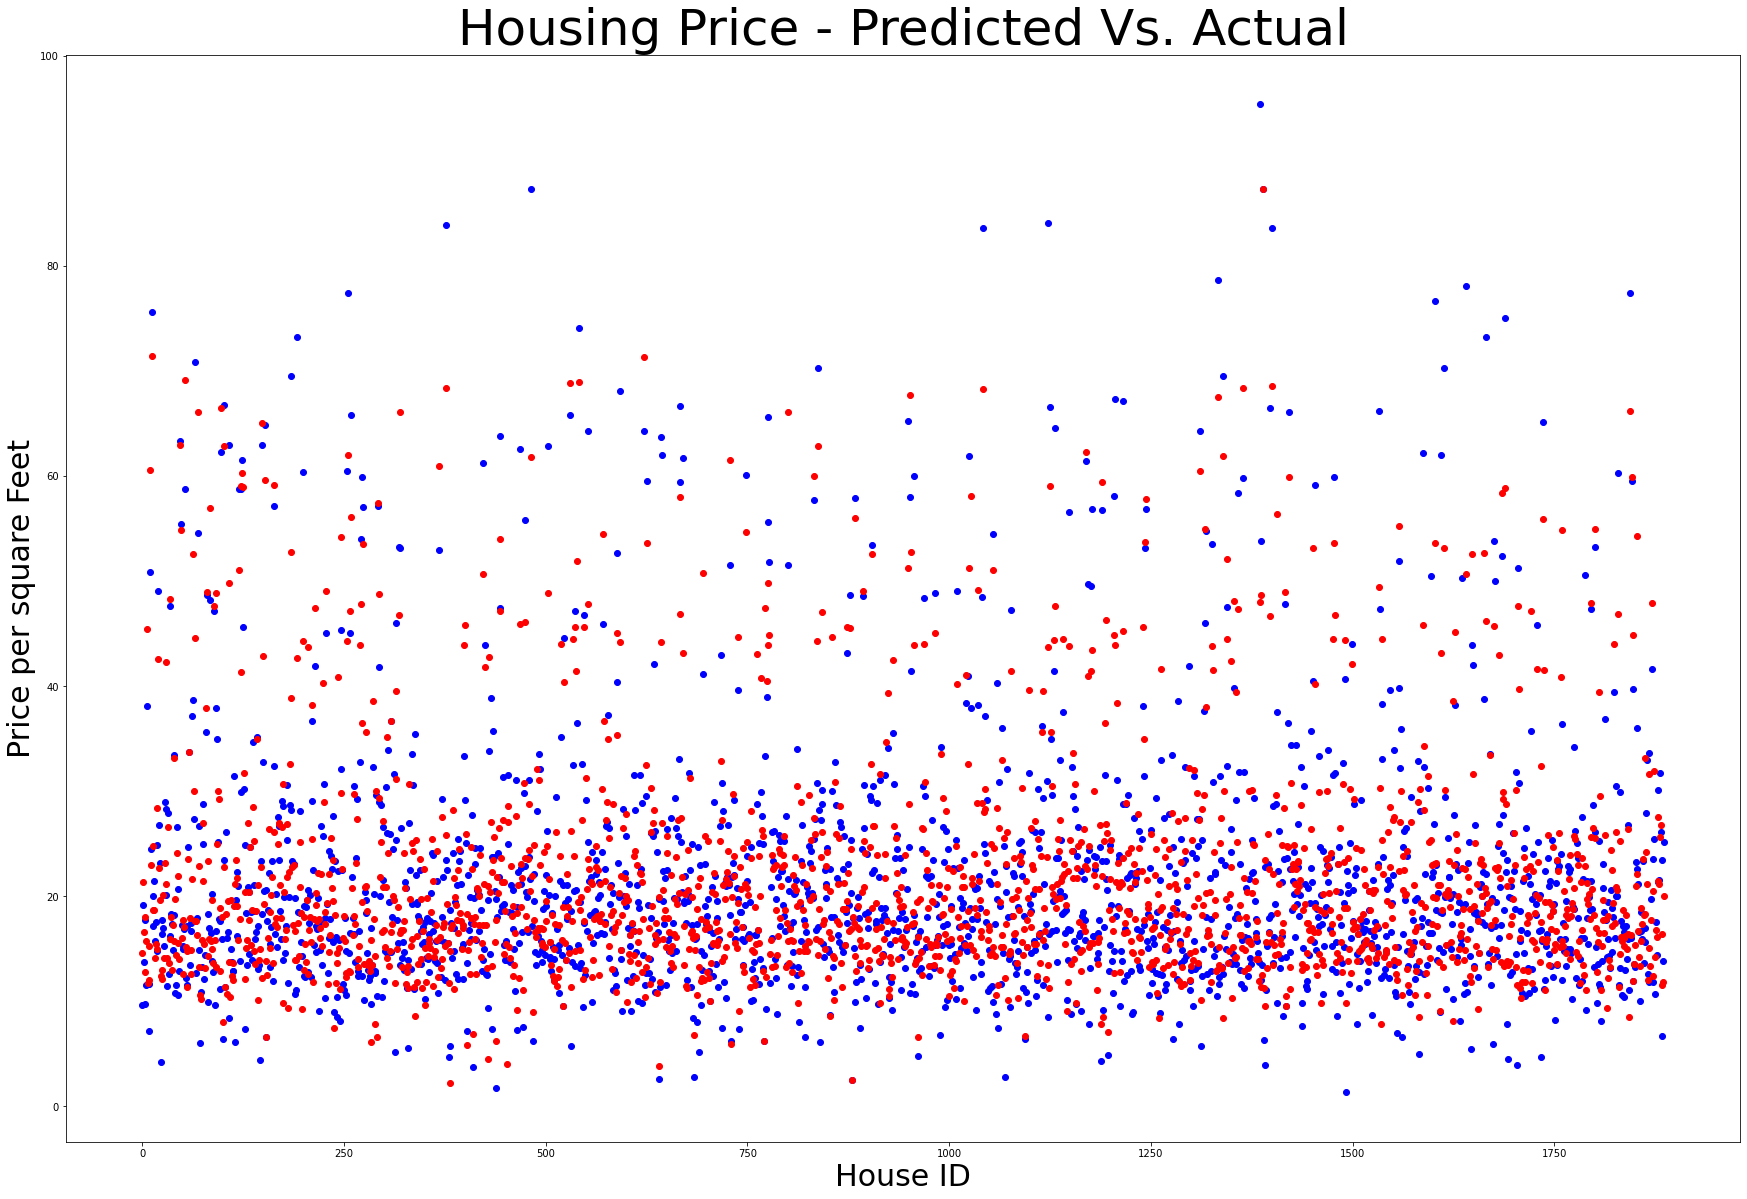

In [197]:
if max(y) >= max(merge_preds):
    my_range = int(max(y))
else:
    my_range = int(max(merge_preds))

plt.figure(figsize=(30, 20))

plt.scatter(range(len(y)), y, color='blue')
plt.scatter(range(len(merge_preds)), merge_preds, color='red')
plt.title("Housing Price - Predicted Vs. Actual", fontsize=50)
plt.xlabel("House ID",fontsize=30)
plt.ylabel("Price per square Feet",fontsize=30)
plt.show()
    

# Source:
# https://stackoverflow.com/questions/65539013/how-to-plot-a-graph-of-actual-vs-predict-values-in-python

For the above scatter plot, if the blue dot is below the red dot, it suggests that the house is undervalued.

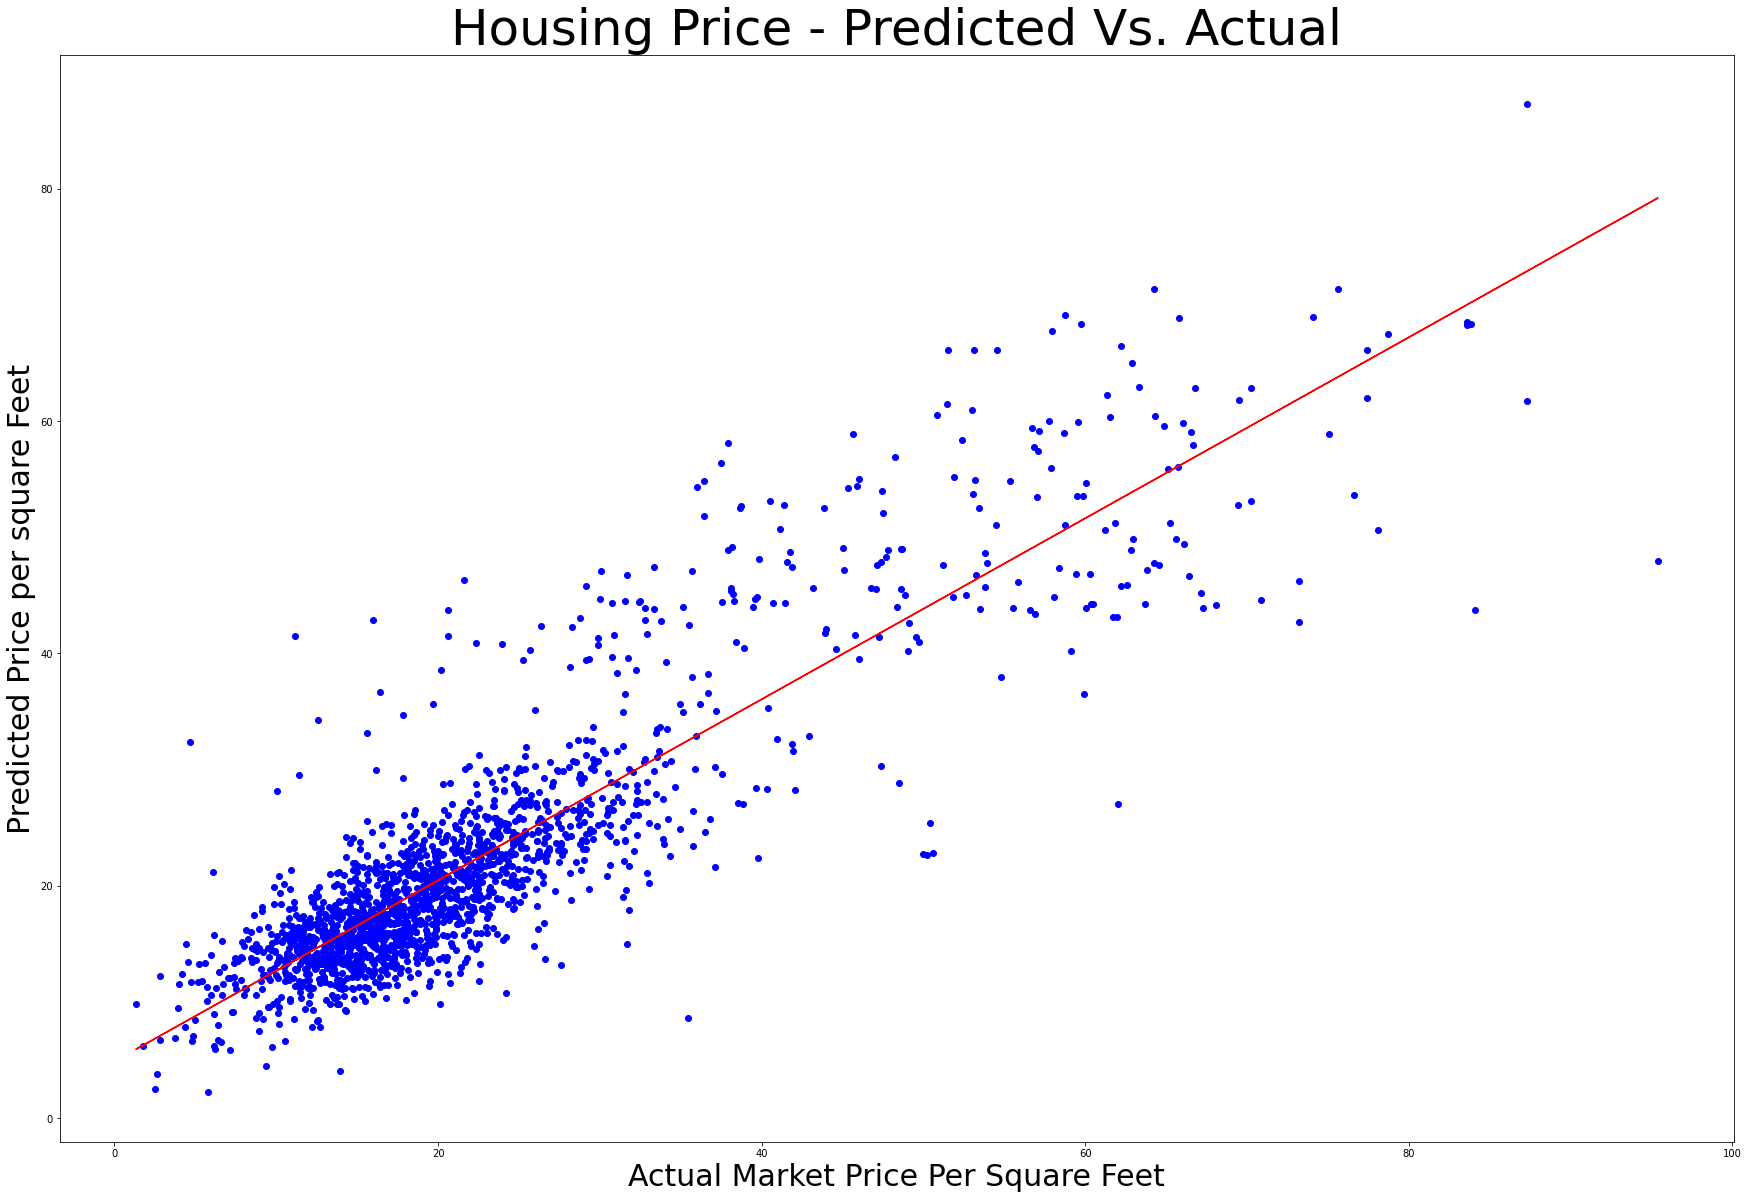

In [192]:

if max(y) >= max(merge_preds):
    my_range = int(max(y))
else:
    my_range = int(max(merge_preds))

plt.figure(figsize=(30, 20))

plt.scatter(y, merge_preds, color='blue')

m, b = np.polyfit(y, merge_preds, 1)
plt.plot(y, m*y+b, color='red')

plt.title("Housing Price - Predicted Vs. Actual",fontsize=50)
plt.xlabel("Actual Market Price Per Square Feet",fontsize=30)
plt.ylabel("Predicted Price per square Feet",fontsize=30)
plt.show()

For the above scatter plot with regression line, points above the regression line indicate that the predicted price is higher than the actual market price, which suggests that the home is undervalued and a good potential investment.

---

## Finding Key Factors Affecting House Prices

In [193]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

{'Lot Shape_IR3': -6.8902760932362295,
 'Lot Config_FR3': -6.0288487261111765,
 'Lot Shape_IR2': -5.069176807709791,
 'Heating_Grav': -4.941892177530597,
 'Condition 2_RRAe': -4.646315046297456,
 'Land Contour_Low': -4.3063735945895925,
 'Condition 2_PosN': -4.274052954651163,
 'Heating_OthW': -3.7917640102093815,
 'Heating_GasW': -2.873398841902832,
 'Land Slope_Sev': -2.8125356364709355,
 'BsmtFin Type 1_Unf': -2.5997023261287993,
 'Condition 1_RRAe': -2.565047269208801,
 'Condition 2_RRNn': -2.444754671488532,
 'Lot Config_FR2': -2.223267555849238,
 'Condition 2_PosA': -1.774517238910934,
 'BsmtFin Type 1_Rec': -1.5761065681984574,
 'MS SubClass_Split': -1.5637475343185372,
 'Foundation_CBlock': -1.4234293137229983,
 'Bldg Type_2fmCon': -1.1832068818603307,
 'BsmtFin Type 1_BLQ': -0.9850474040544301,
 'MS SubClass_Split Foyer': -0.9736594686397115,
 'Condition 2_RRAn': -0.9273406166743852,
 'BsmtFin Type 2_BLQ': -0.853630668308603,
 'BsmtFin Type 2_Rec': -0.6935458126929217,
 'MS Su

In [194]:
{k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}

{'MS SubClass_1.5 Storey PUD': 42.49889799224564,
 'Roof Matl_WdShake': 22.19286250165288,
 'Roof Matl_CompShg': 21.958317124846896,
 'MS SubClass_2 Storey PUD': 21.629920574480156,
 'Roof Matl_Membran': 20.12172183237384,
 'Bldg Type_Twnhs': 19.05273460126282,
 'Roof Matl_Tar&Grv': 18.562168807976317,
 'Roof Matl_WdShngl': 18.174607456945083,
 'MS SubClass_PUD Multi': 15.282863245280451,
 'MS SubClass_1 Storey PUD': 13.223391144455382,
 'MS Zoning_Floating Village Residential': 6.1297529240033075,
 'Bldg Type_TwnhsE': 5.534062374374795,
 'Condition 1_PosN': 4.0392357245219666,
 'MS Zoning_Residential Medium Density': 3.7981446765948625,
 'Utilities': 3.14298862655741,
 'Land Contour_HLS': 2.88333705751889,
 'MS SubClass_2 Storey 1946 Older': 2.860331129700092,
 'Street_Pave': 2.1343604017254623,
 'Condition 2_Feedr': 1.9847552709119123,
 'MS SubClass_1.5 Unfinished': 1.8540099404232775,
 'Condition 1_Feedr': 1.781133314123288,
 'Land Slope_Mod': 1.7707099523395018,
 'Lot Shape_Reg': 1

In [195]:
y.sort_values() # price per sqaure feet

1492     1.324461
438      1.742138
880      2.504422
641      2.622689
684      2.797203
          ...    
376     83.845064
1122    84.067393
1389    87.294118
482     87.319666
1385    95.384615
Name: Price Per Sq Ft, Length: 1887, dtype: float64

In [196]:
coef_dict.keys()

dict_keys(['MS SubClass_1 Storey Newer All', 'MS SubClass_1 Storey PUD', 'MS SubClass_1 Storey W/Finished Attic', 'MS SubClass_1.5 Finished', 'MS SubClass_1.5 Storey PUD', 'MS SubClass_1.5 Unfinished', 'MS SubClass_2 Storey 1946 Newer', 'MS SubClass_2 Storey 1946 Older', 'MS SubClass_2 Storey PUD', 'MS SubClass_2.5 Story All', 'MS SubClass_Duplex All', 'MS SubClass_Family Conversion', 'MS SubClass_PUD Multi', 'MS SubClass_Split', 'MS SubClass_Split Foyer', 'MS Zoning_Floating Village Residential', 'MS Zoning_Residential High Density', 'MS Zoning_Residential Low Density', 'MS Zoning_Residential Medium Density', 'Lot Config_CulDSac', 'Lot Config_FR2', 'Lot Config_FR3', 'Lot Config_Inside', 'Condition 1_Feedr', 'Condition 1_Norm', 'Condition 1_PosA', 'Condition 1_PosN', 'Condition 1_RRAe', 'Condition 1_RRAn', 'Condition 1_RRNe', 'Condition 1_RRNn', 'Condition 2_Feedr', 'Condition 2_Norm', 'Condition 2_PosA', 'Condition 2_PosN', 'Condition 2_RRAe', 'Condition 2_RRAn', 'Condition 2_RRNn', '

### **Factors with greatest positive effects**

|Factors|Coefficient Effect|Description|
|----|----|----|
|'Roof Matl_WdShake':| 22.19286250165288,     |   WdShake	Wood Shakes|
|'Roof Matl_CompShg': |21.958317124846896,    |    CompShg	Standard (Composite) Shingle|
|'MS SubClass_2 Storey PUD':| 21.629920574480156, |       160	2-STORY PUD - 1946 & NEWER|
|'Roof Matl_Membran': |20.12172183237384,    |   Membran	Membrane|
|'Bldg Type_Twnhs': |19.05273460126282,    |    TwnhsI	Townhouse Inside Unit|
|'Roof Matl_Tar&Grv':| 18.562168807976317, |       Tar&Grv	Gravel & Tar|
|'Roof Matl_WdShngl': |18.174607456945083, |      WdShngl	Wood Shingles|
|'MS SubClass_PUD Multi': |15.282863245280451,  |      180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER|
|'MS SubClass_1 Storey PUD':| 13.223391144455382, |       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER|
|'MS Zoning_Floating Village Residential': |6.1297529240033075,|       FV	Floating Village Residential|
|'Bldg Type_TwnhsE': |5.534062374374795,    |    TwnhsE	Townhouse End Unit|
|'Condition 1_PosN':| 4.0392357245219666,   |     PosN	Near positive off-site feature--park, greenbelt, etc.|
|'MS Zoning_Residential Medium Density':| 3.7981446765948625,  |      RM	Residential Medium Density|
|'Utilities':| 3.14298862655741,     |   AllPub	All public Utilities (E,G,W,& S)	|
|'Land Contour_HLS':| 2.88333705751889,   |     HLS	Hillside - Significant slope from side to side|
|'MS SubClass_2 Storey 1946 Older':| 2.860331129700092,  |      070	2-STORY 1946 & OLDER|
|'Street_Pave':| 2.1343604017254623,   |     Pave	Paved|
|'Condition 2_Feedr':| 1.9847552709119123,    |    Feedr	Adjacent to feeder street	|
|'MS SubClass_1.5 Unfinished':| 1.8540099404232775, |       045	1-1/2 STORY - UNFINISHED ALL AGES|
|'Condition 1_Feedr': |1.781133314123288,  |      Feedr	Adjacent to feeder street	|
|'Land Slope_Mod': |1.7707099523395018,    |    Mod	Moderate Slope	|
|'Lot Shape_Reg': |1.7644860598293786,   |     Reg 	Regular	|
|'Condition 1_RRNn': |1.597013362470702,  |      RRNn	Within 200' of North-South Railroad|
|'Condition 1_Norm': |1.5206481173536721,    |    Norm	Normal	|


---

### **Factors with greatest negative effects**


|Factors|Coefficient Effect|Description|
|----|----|----|
|'Lot Shape_IR3': |-6.8902760932362295,|        IR3	Irregular|
|'Lot Config_FR3': |-6.0288487261111765,| FR3	Frontage on 3 sides of property <br /> It is the measurement of the length of a plot of land or a building<br />facing the main road on to which the plot or building fronts.|
|'Lot Shape_IR2': |-5.069176807709791,|       IR2	Moderately Irregular|
|'Heating_Grav': |-4.941892177530597,  |     Grav	Gravity furnace	|
|'Condition 2_RRAe': |-4.646315046297456 |              RRAe	Adjacent to East-West Railroad|
|'Land Contour_Low': |-4.3063735945895925,  |     Low	Depression|
|'Condition 2_PosN': |-4.274052954651163,|       PosN	Near positive off-site feature--park, greenbelt, etc.|
|'Heating_OthW': |-3.7917640102093815,   |     OthW	Hot water or steam heat other than gas|
|'Heating_GasW': |-2.873398841902832,   |     GasW	Gas hot water or steam heat|
|'Land Slope_Sev': |-2.8125356364709355, |       Sev	Severe Slope|
|'BsmtFin Type 1_Unf': |-2.5997023261287993,|       Unf	Unfinshed|
|'Condition 1_RRAe': |-2.565047269208801,|       RRAe	Adjacent to East-West Railroad|
|'Condition 2_RRNn': |-2.444754671488532,|       RRNn	Within 200' of North-South Railroad|
|'Lot Config_FR2': |-2.223267555849238,     |  FR2	Frontage on 2 sides of property|
|'Condition 2_PosA': |-1.774517238910934,|       PosA	Adjacent to postive off-site feature|
|'BsmtFin Type 1_Rec': |-1.5761065681984574,|       Rec	Average Rec Room|
|'MS SubClass_Split': |-1.5637475343185372,    |   080	SPLIT OR MULTI-LEVEL|
|'Foundation_CBlock': |-1.4234293137229983,|       CBlock	Cinder Block|
|'Bldg Type_2fmCon': |-1.1832068818603307,|       2FmCon	Two-family Conversion; originally built as one-family dwelling|

---

---

# [Post] Pipeline 

My aim is to improve my score for the predictions.

I will also use other Scalers like Robust Scalers and Log Transform

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html